In [22]:
import pandas as pd

# 파일 경로
file_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_result_D_agg_3h.xlsx'

df = pd.read_excel(file_path)

# info 출력
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355 entries, 0 to 1354
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   issue           1355 non-null   object        
 1   datetime_3h     1355 non-null   datetime64[ns]
 2   channel         1355 non-null   object        
 3   viewCount       1355 non-null   int64         
 4   likeCount       1355 non-null   int64         
 5   comment_cnt     1355 non-null   int64         
 6   aligned_cnt_3h  1355 non-null   int64         
 7   aligned_cnt_6h  1355 non-null   int64         
 8   aligned_cnt_9h  1355 non-null   int64         
 9   match_sum       1355 non-null   int64         
 10  Entity          1355 non-null   int64         
 11  Event           1355 non-null   int64         
 12  Cause           1355 non-null   int64         
 13  Impact          1355 non-null   int64         
 14  Reaction        1355 non-null   int64         
 15  Lfla

In [23]:
import pandas as pd
import numpy as np

# 방어적 함수
def safe_log(x):
    return np.log(1 + max(x, 0))

def safe_pow(x, p):
    return max(x, 0) ** p

def safe_div(a, b):
    return a / b if b > 0 else 0

# 플랫폼별 W 계산
def calc_youtube(row):
    """유튜브: 데이터 풍부 + 라벨링"""
    # a: 최대 위험
    view = max(row.get('viewCount', 0), 0)
    a = (row.get('comment_cnt', 0) +
         0.001 * safe_pow(view, 0.7) +
         0.1 * row.get('likeCount', 0))

    # b: 초기 속도
    sent = (row.get('post_s', 0) + row.get('cmt_s_mean', 0)) / 2
    growth = safe_div(max(row.get('aligned_cnt_9h', 1), 1), max(row.get('aligned_cnt_3h', 1), 1))
    b = 1 + 2 * sent + safe_log(growth)

    # c, xi
    c = 1.0
    xi = safe_log(growth)

    return a * np.exp(-b * np.exp(-c * xi))

def calc_naver(row):
    """네이버: 댓글 + 라벨링 + 증가율"""
    # a: 최대 위험
    match_sum = row.get('Entity', 0) + row.get('Event', 0) + row.get('Cause', 0) + row.get('Impact', 0) + row.get('Reaction', 0)
    a = row.get('comment_cnt', 0) * (1 + 0.5 * match_sum)

    # b: 초기 속도
    sent = (row.get('post_s', 0) + row.get('cmt_s_mean', 0)) / 2
    growth = safe_div(max(row.get('aligned_cnt_9h', 1), 1), max(row.get('aligned_cnt_3h', 1), 1))
    b = 1 + 2 * sent + safe_log(growth)

    # c, xi
    c = 1.2
    xi = safe_log(growth)

    return a * np.exp(-b * np.exp(-c * xi))

def calc_twitter_blog(row):
    """트위터/블로그: 부정 가정 + 라벨링 + 정율"""
    # a: 최대 위험 (부정 가정 보정)
    match_sum = row.get('Entity', 0) + row.get('Event', 0) + row.get('Cause', 0) + row.get('Impact', 0) + row.get('Reaction', 0)
    a = row.get('count', 0) * (1 + 0.5 * match_sum) * 1.5

    # b: 초기 속도 (증가율만)
    growth = row.get('count', 0)
    b = 1 + safe_log(growth)

    # c, xi
    c = 1.5
    xi = safe_log(growth)

    return a * np.exp(-b * np.exp(-c * xi))

# 통합 W 계산
def calc_w_complete(df):
    """
    df: pandas DataFrame (플랫폼별로 계산)
    """
    # 플랫폼별 계산
    df['W_Y'] = df.apply(lambda r: calc_youtube(r) if str(r.get('channel', '')).lower() in ['youtube', '유튜브'] else 0, axis=1)
    df['W_N'] = df.apply(lambda r: calc_naver(r) if str(r.get('channel', '')).lower() in ['naver', '네이버'] else 0, axis=1)
    df['W_T'] = df.apply(lambda r: calc_twitter_blog(r) if str(r.get('channel', '')).lower() in ['twitter', '트위터', 'blog', '블로그'] else 0, axis=1)

    # 정규화 (실제 데이터 기반)
    MAX_Y = max(df['W_Y'].max(), 1)
    MAX_N = max(df['W_N'].max(), 1)
    MAX_T = max(df['W_T'].max(), 1)

    # 최종 W (시그모이드)
    x = (df['W_Y'] / MAX_Y) + 2 * (df['W_N'] / MAX_N) + 2.5 * (df['W_T'] / MAX_T) - 0.5
    df['W_final'] = 10 / (1 + np.exp(-4 * x))

    return df

# 예시 실행 (사용시 주석 해제)
# df = pd.DataFrame([...])  # 입력 데이터
# result = calc_w_complete(df)
# print(result[['channel', 'W_Y', 'W_N', 'W_T', 'W_final']])

In [24]:
result = calc_w_complete(df)
print(result[['channel', 'W_Y', 'W_N', 'W_T', 'W_final']])

      channel  W_Y  W_N        W_T   W_final
0        blog  0.0  0.0   1.648712  1.195037
1        blog  0.0  0.0   3.297424  1.198051
2        blog  0.0  0.0   2.473068  1.196543
3     twitter  0.0  0.0  42.759390  1.272168
4     twitter  0.0  0.0  61.763564  1.309240
...       ...  ...  ...        ...       ...
1350      네이버  0.0  0.0   0.000000  1.192029
1351      네이버  0.0  0.0   0.000000  1.192029
1352      네이버  0.0  0.0   0.000000  1.192029
1353      네이버  0.0  0.0   0.000000  1.192029
1354      네이버  0.0  0.0   0.000000  1.192029

[1355 rows x 5 columns]


In [25]:
# 채널별 데이터를 한 줄씩 보여주는 데이터프레임
channel_first_rows = df.groupby('channel').head(1).reset_index(drop=True)
channel_first_rows

,issue,datetime_3h,channel,viewCount,likeCount,comment_cnt,aligned_cnt_3h,aligned_cnt_6h,aligned_cnt_9h,match_sum,...,Reaction,Lflag,abs_sent_gap,D,count,Lnorm,W_Y,W_N,W_T,W_final
0,GS,2024-12-26 12:00:00,blog,0,0,0,0,0,0,2,...,0,0,NaN,NaN,1,NaN,0.000000,0.000000,1.648712,1.195037
1,GS,2025-01-05 18:00:00,twitter,0,0,0,0,0,0,16,...,1,0,NaN,0.911500,4,NaN,0.000000,0.000000,42.759390,1.272168
2,GS,2025-01-06 15:00:00,유튜브,33,0,0,0,0,0,6,...,0,0,1.000000,0.943000,1,0.069067,0.004958,0.000000,0.000000,1.192031
3,GS,2025-01-06 21:00:00,네이버,0,0,65,19,22,24,124,...,1,23,0.719565,0.978609,23,0.548429,0.000000,2070.920908,0.000000,1.390375


In [5]:
df_final=df

In [26]:
df['W'] = np.select(
    [
        df['channel'].str.lower().isin(['blog', '블로그', 'twitter', '트위터']),
        df['channel'].str.lower().isin(['youtube', '유튜브']),
        df['channel'].str.lower().isin(['naver', '네이버'])
    ],
    [
        df['W_T'],
        df['W_Y'],
        df['W_N']
    ],
    default=np.nan
)


In [29]:
df.head()

,issue,datetime_3h,channel,viewCount,likeCount,comment_cnt,aligned_cnt_3h,aligned_cnt_6h,aligned_cnt_9h,match_sum,...,Lflag,abs_sent_gap,D,count,Lnorm,W_Y,W_N,W_T,W_final,W
0,GS,2024-12-26 12:00:00,blog,0,0,0,0,0,0,2,...,0,NaN,NaN,1,NaN,0.0,0.0,1.648712,1.195037,1.648712
1,GS,2025-01-02 09:00:00,blog,0,0,0,0,0,0,6,...,0,NaN,1.0000,1,NaN,0.0,0.0,3.297424,1.198051,3.297424
2,GS,2025-01-03 06:00:00,blog,0,0,0,0,0,0,4,...,0,NaN,0.9760,1,NaN,0.0,0.0,2.473068,1.196543,2.473068
3,GS,2025-01-05 18:00:00,twitter,0,0,0,0,0,0,16,...,0,NaN,0.9115,4,NaN,0.0,0.0,42.759390,1.272168,42.759390
4,GS,2025-01-05 21:00:00,twitter,0,0,0,0,0,0,24,...,0,NaN,0.9520,4,NaN,0.0,0.0,61.763564,1.309240,61.763564


In [30]:
df.to_excel('output.xlsx', index=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime_3h     602 non-null    datetime64[ns]
 1   channel         602 non-null    object        
 2   viewCount       602 non-null    int64         
 3   likeCount       602 non-null    int64         
 4   comment_cnt     602 non-null    int64         
 5   aligned_cnt_3h  602 non-null    int64         
 6   aligned_cnt_6h  602 non-null    int64         
 7   aligned_cnt_9h  602 non-null    int64         
 8   match_sum       602 non-null    int64         
 9   post_s          297 non-null    float64       
 10  cmt_s_mean      297 non-null    float64       
 11  Entity          602 non-null    int64         
 12  Event           602 non-null    int64         
 13  Cause           602 non-null    int64         
 14  Impact          602 non-null    int64         
 15  Reacti

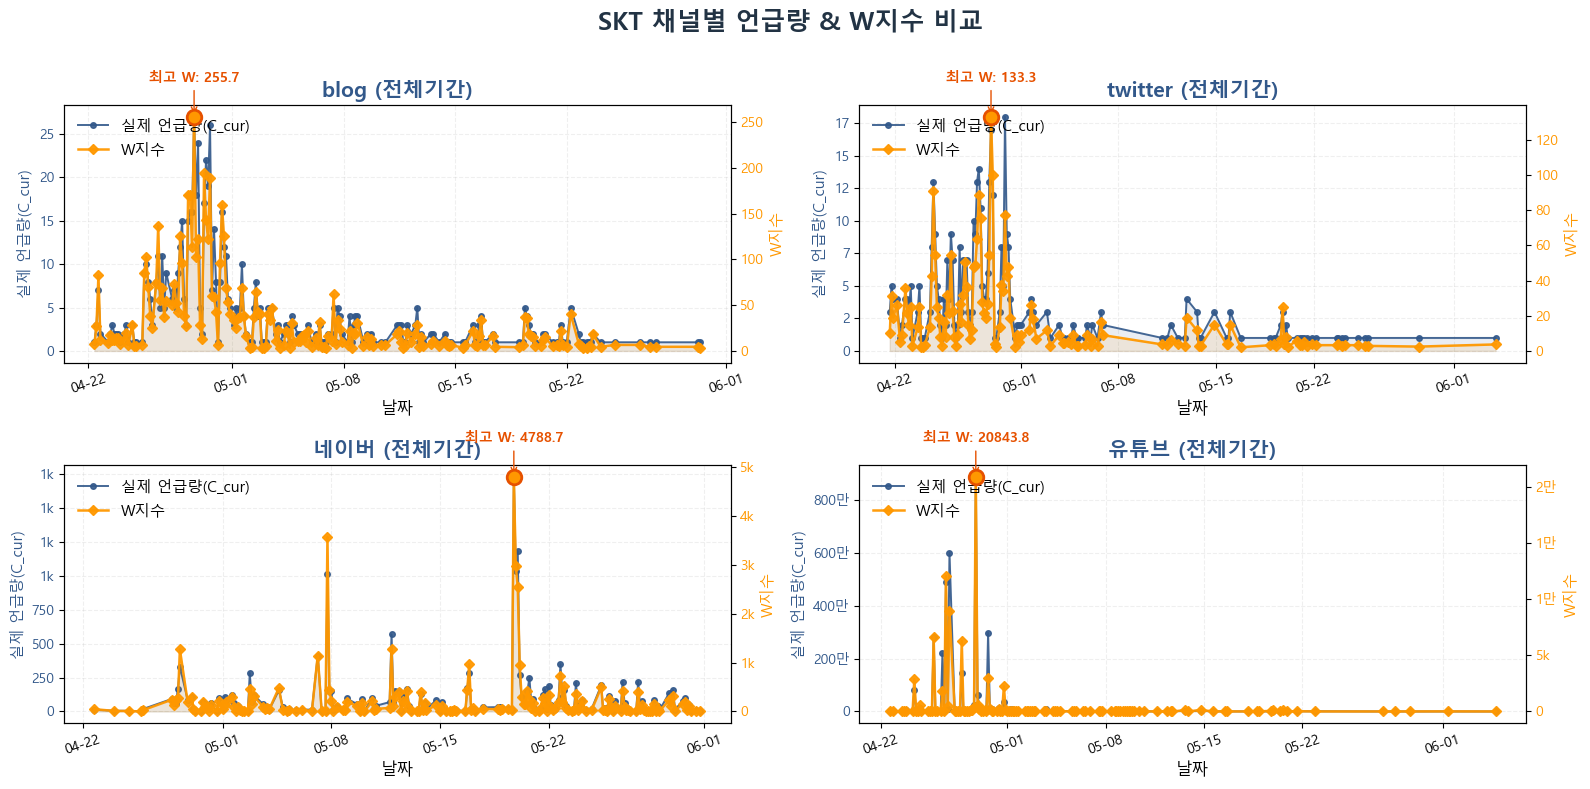

           datetime_3h channel  C_cur          W
4  2025-04-22 09:00:00    blog      1   7.831382
6  2025-04-22 12:00:00    blog      3  26.715185
8  2025-04-22 15:00:00    blog      7  82.475927
10 2025-04-22 18:00:00    blog      2  12.019059
17 2025-04-23 06:00:00    blog      1   8.243560
19 2025-04-23 09:00:00    blog      2  17.027000
20 2025-04-23 12:00:00    blog      3  11.687894
22 2025-04-23 15:00:00    blog      2  12.019059
25 2025-04-23 18:00:00    blog      2  14.022235
28 2025-04-23 21:00:00    blog      2  14.022235

[채널별 W_norm 값 테이블]
           datetime_3h channel    W_norm
4  2025-04-22 09:00:00    blog  0.195945
6  2025-04-22 12:00:00    blog  0.468860
8  2025-04-22 15:00:00    blog  0.731968
10 2025-04-22 18:00:00    blog  0.288559
17 2025-04-23 06:00:00    blog  0.206831
19 2025-04-23 09:00:00    blog  0.366222
20 2025-04-23 12:00:00    blog  0.282410
22 2025-04-23 15:00:00    blog  0.288559
25 2025-04-23 18:00:00    blog  0.322711
28 2025-04-23 21:00:00    blog 

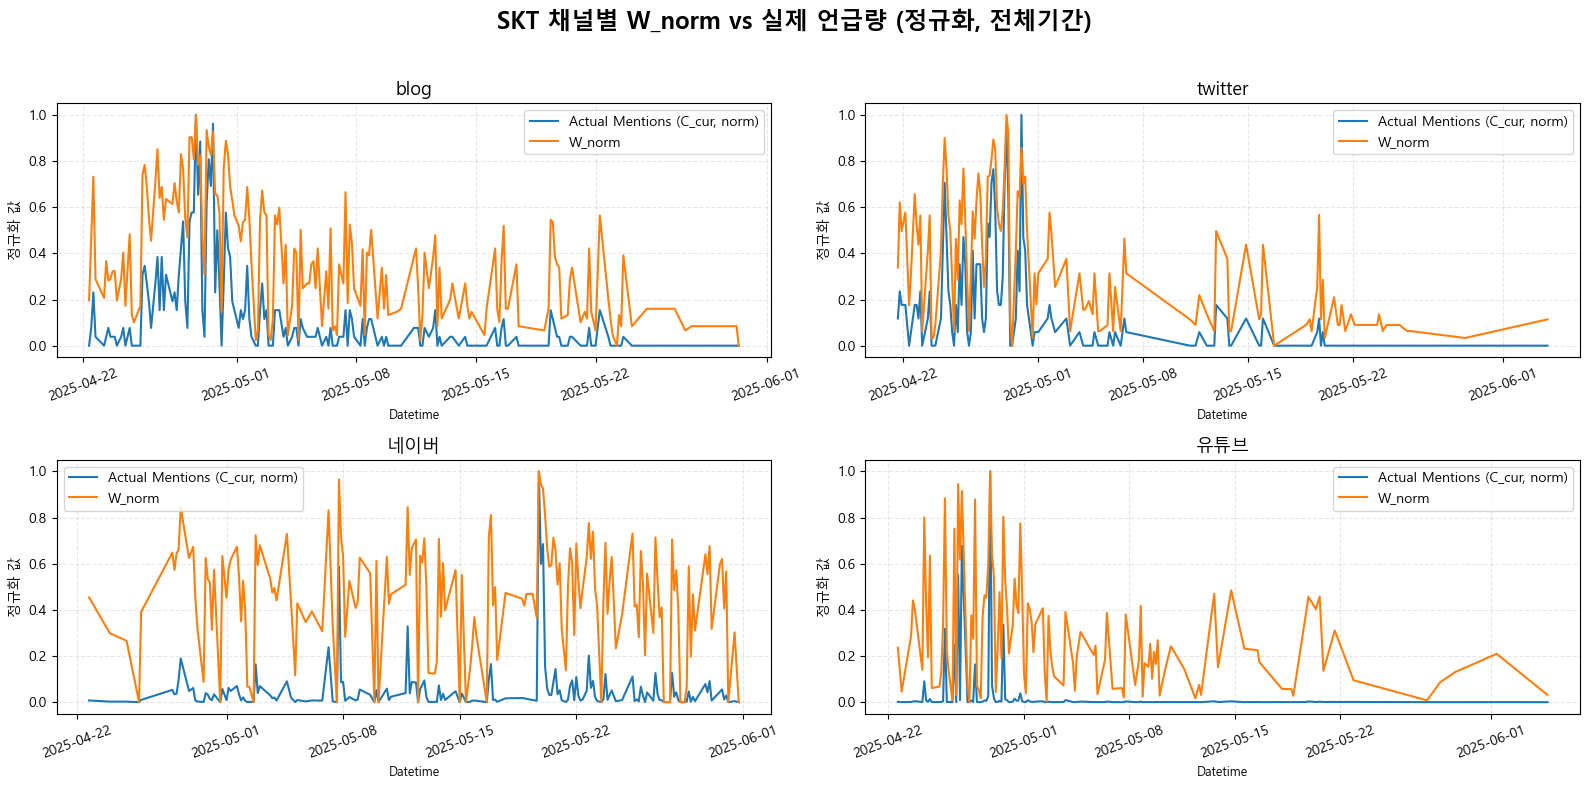

In [42]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 한글 깨짐 방지 (운영체제별 폰트 자동 설정)
file_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\SKT_3시간_단위_채널별_집계_withCount.xlsx'

df = pd.read_excel(file_path)

# info 출력
df.info()

result = calc_w_complete(df)
print(result[['channel', 'W_Y', 'W_N', 'W_T', 'W_final']])

# W 컬럼 추가
df['W'] = np.select(
    [
        df['channel'].str.lower().str.contains('blog|블로그|twitter|트위터'),
        df['channel'].str.lower().str.contains('youtube|유튜브'),
        df['channel'].str.lower().str.contains('naver|네이버')
    ],
    [
        df['W_T'],    # 블로그, 트위터
        df['W_Y'],    # 유튜브
        df['W_N']     # 네이버
    ],
    default=np.nan
)

# ✅ 추가: 채널별 W_Y, W_N, W_T, W 값 표 출력
w_table = df.groupby('channel').agg({'W_Y':'first', 'W_N':'first', 'W_T':'first', 'W':'first'}).reset_index()
w_table = w_table.rename(columns={'W_Y': 'W_Y', 'W_N':'W_N', 'W_T':'W_T', 'W':'W'})
print("\n[채널별 W_Y, W_N, W_T, W 값 표]")
print(w_table)

mask = (
    (df['datetime_3h'].dt.month == 4) | 
    ((df['datetime_3h'].dt.month == 5) & (df['datetime_3h'].dt.day <= 10))
)
df_final = df[mask].copy()
df_final.sort_values(['channel', 'datetime_3h'], inplace=True)

df_final = df.copy()  # 전체 데이터 사용

from matplotlib import font_manager, rc
import platform
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# ===============================
# ✅ 데이터 준비 및 피처 엔지니어링
# ===============================
def calc_Ccur(row):
    ch = str(row['channel']).strip().lower()
    if 'youtube' in ch or '유튜브' in ch:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']
    elif 'naver' in ch or '네이버' in ch:
        return row['comment_cnt'] + row['count']
    elif 'twitter' in ch or '트위터' in ch or 'blog' in ch or '블로그' in ch:
        return row['count']
    else:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']

df_final['C_cur'] = df_final.apply(calc_Ccur, axis=1)

# 전체 데이터 정렬
df_final.sort_values(['channel', 'datetime_3h'], inplace=True)

import matplotlib.dates as mdates

channels = df_final['channel'].unique()
n_ch = len(channels)
ncols = 2
nrows = int(np.ceil(n_ch / 2))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows*4), sharex=False)
axes = axes.flatten()

for idx, ch in enumerate(channels):
    chan_df = df_final[df_final['channel'] == ch]
    ax1 = axes[idx]
    color_c = "#32588a"
    color_w = "#ff9800"
    
    # X축 포맷 지정 (전체 데이터이므로 월-일 자동)
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    # C_cur plot (라인 더 얇고, 점을 강조)
    ax1.plot(
        chan_df['datetime_3h'], 
        chan_df['C_cur'], 
        color=color_c, 
        marker='o',
        markersize=4,
        label='실제 언급량(C_cur)', 
        linewidth=1.4,    # 기존 2.5 에서 1.4로 더 얇게 변경
        alpha=0.9, 
        zorder=2
    )
    ax1.fill_between(chan_df['datetime_3h'], 0, chan_df['C_cur'],
                     color=color_c, alpha=0.10, zorder=1)
    
    # W plot (선 두께를 줄이고, 점 강조 및 라인을 미묘하게 부드럽게)
    ax2 = ax1.twinx()
    ax2.plot(
        chan_df['datetime_3h'], 
        chan_df['W'], 
        color=color_w,
        marker='D', 
        markersize=5,    # 기존 6에서 5로 줄임
        linestyle='-', 
        linewidth=1.8,   # 기존 3에서 1.8로 얇게
        alpha=0.95,
        label='W지수', 
        zorder=3
    )
    ax2.fill_between(chan_df['datetime_3h'], 0, chan_df['W'],
                     color=color_w, alpha=0.10, zorder=1)
    
    # W 최대값 위치에 점 강조 (크기는 기존과 동일)
    wmax_idx = chan_df['W'].idxmax()
    wmax_time = chan_df.loc[wmax_idx, 'datetime_3h']
    wmax_val = chan_df.loc[wmax_idx, 'W']
    ax2.scatter(wmax_time, wmax_val, s=110, color=color_w, edgecolor='#e65100',
                linewidth=2, zorder=10)
    ax2.annotate(
        f"최고 W: {wmax_val:.1f}",
        xy=(wmax_time, wmax_val),
        xytext=(0, 25), textcoords='offset points',
        ha='center', fontsize=10, fontweight='bold',
        color='#e65100', arrowprops=dict(arrowstyle='->', color='#e65100')
    )
    
    ax1.set_title(f"{ch} (전체기간)", fontsize=15, fontweight='bold', color='#32588a')
    ax1.set_xlabel("날짜", fontsize=12)
    ax1.set_ylabel("실제 언급량(C_cur)", fontsize=11, color=color_c)
    ax2.set_ylabel("W지수", fontsize=11, color=color_w)
    ax1.tick_params(axis='y', labelcolor=color_c)
    ax2.tick_params(axis='y', labelcolor=color_w)
    
    # 범례 이쁘게
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=11, frameon=False)

    ax1.grid(alpha=0.2, linestyle='--')
    ax1.set_axisbelow(True)
    ax1.xaxis.set_tick_params(rotation=18)
    
    # 지수값 포멧: 만 단위로 보기 좋게 포맷 (예: 10,000 -> 1만)
    def man_format(x, _):
        if x >= 10000:
            return f'{int(x)//10000}만'
        elif x >= 1000:
            return f'{int(x)//1000}k'
        else:
            return f'{int(x):,}'
    ax1.yaxis.set_major_formatter(FuncFormatter(man_format))
    ax2.yaxis.set_major_formatter(FuncFormatter(man_format))

# 나머지 빈 subplot 제거
for i in range(n_ch, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("SKT 채널별 언급량 & W지수 비교 ", fontsize=18, fontweight='bold', color='#234')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# 결과 미리보기 (전체 데이터, 채널별)
print(df_final[['datetime_3h', 'channel', 'C_cur',  'W']].head(10))

# 채널별 로그 정규화
df_final["W_log"] = np.log1p(df_final["W"])  # log(1 + W)

# 채널별로 다시 0~1 정규화
df_final["W_norm"] = df_final.groupby("channel")["W_log"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9)
)

# 추가: W_norm 값 테이블로 보여주고 df25에 저장
dfSK = df_final[['datetime_3h', 'channel', 'W_norm']].copy()
print("\n[채널별 W_norm 값 테이블]")
print(dfSK.head(10))

# 결과 확인
print(df_final.groupby("channel")["W_norm"].agg(["min", "max"]).head())

output_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\SKT_W.xlsx'
df_final.to_excel(output_path, index=False, engine="openpyxl")
print(f"✅ 채널별 정규화 완료 및 저장: {output_path}")

import matplotlib.pyplot as plt

# 'W_norm'과 실제 언급량(C_cur)을 채널별로 비교, 2x2 subplot으로 시각화 
channels = df_final['channel'].unique()
channels_to_plot = channels[:4]  # 최대 4개 채널만 예시로 2x2에
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False)
axes = axes.flatten()

for idx, channel in enumerate(channels_to_plot):
    ax = axes[idx]
    sub = df_final[df_final['channel'] == channel].copy()
    # Normalize C_cur 도 0~1 범위로 비교
    ccur_norm = (sub['C_cur'] - sub['C_cur'].min()) / (sub['C_cur'].max() - sub['C_cur'].min() + 1e-9)
    ax.plot(sub['datetime_3h'], ccur_norm, label='Actual Mentions (C_cur, norm)', color='tab:blue')
    ax.plot(sub['datetime_3h'], sub['W_norm'], label='W_norm', color='tab:orange')
    ax.set_title(f"{channel}", fontsize=13)
    ax.legend(fontsize=10)
    ax.set_ylabel("정규화 값")
    ax.set_xlabel("Datetime", fontsize=9)
    ax.tick_params(axis='x', rotation=20)
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(len(channels_to_plot), 4):
    fig.delaxes(axes[j])

fig.suptitle("SKT 채널별 W_norm vs 실제 언급량 (정규화, 전체기간)", fontsize=17, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime_3h     128 non-null    datetime64[ns]
 1   channel         128 non-null    object        
 2   viewCount       128 non-null    int64         
 3   likeCount       128 non-null    int64         
 4   comment_cnt     128 non-null    int64         
 5   aligned_cnt_3h  128 non-null    int64         
 6   aligned_cnt_6h  128 non-null    int64         
 7   aligned_cnt_9h  128 non-null    int64         
 8   match_sum       128 non-null    int64         
 9   post_s          71 non-null     float64       
 10  cmt_s_mean      71 non-null     float64       
 11  Entity          128 non-null    int64         
 12  Event           128 non-null    int64         
 13  Cause           128 non-null    int64         
 14  Impact          128 non-null    int64         
 15  Reacti

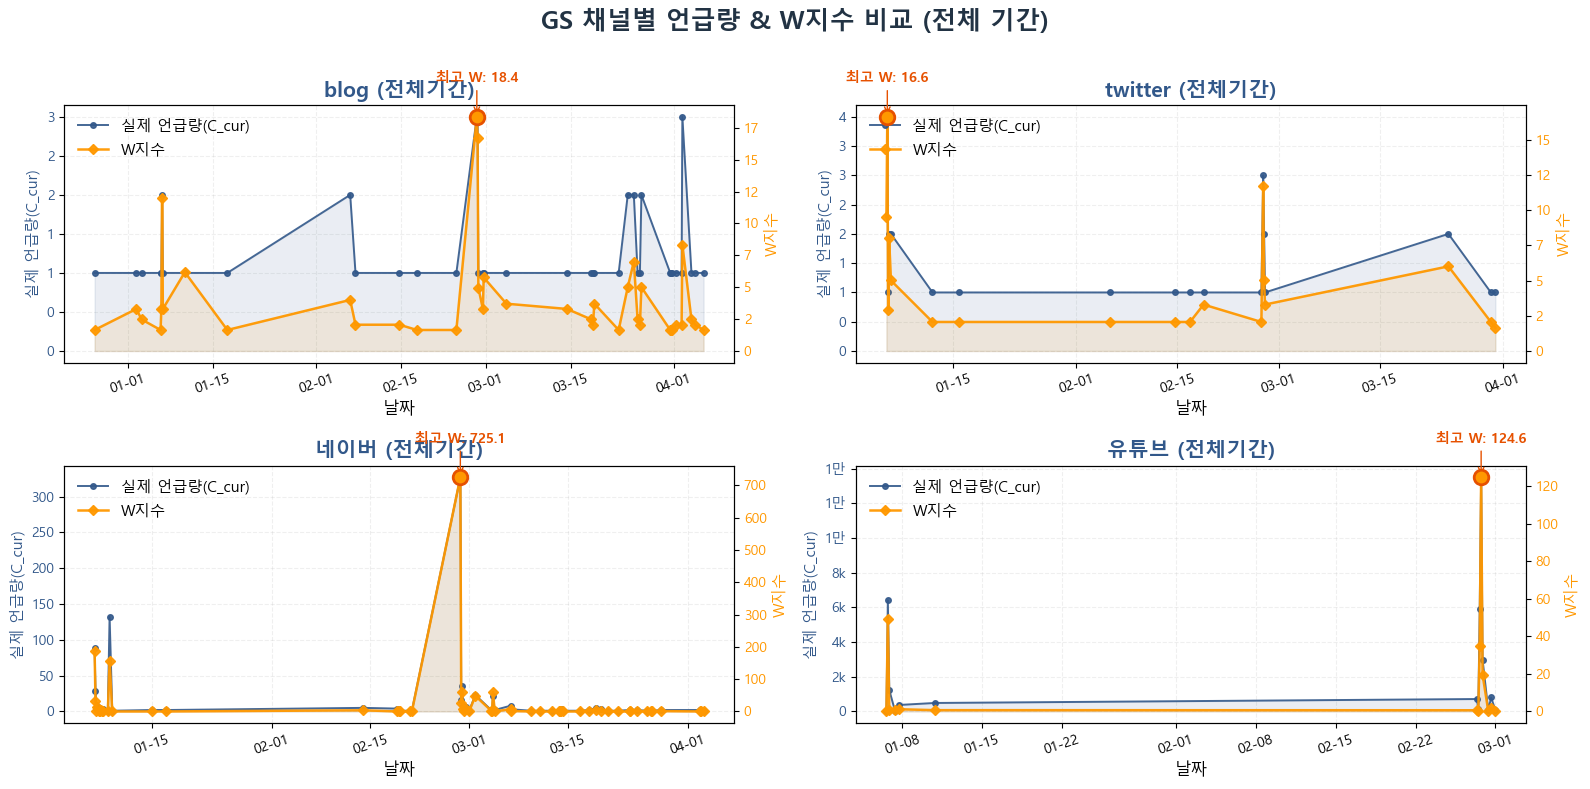

           datetime_3h channel  C_cur          W
0  2024-12-26 12:00:00    blog      1   1.648712
1  2025-01-02 09:00:00    blog      1   3.297424
2  2025-01-03 06:00:00    blog      1   2.473068
7  2025-01-06 09:00:00    blog      1   1.648712
9  2025-01-06 12:00:00    blog      1   3.297424
10 2025-01-06 15:00:00    blog      2  12.019059
12 2025-01-06 18:00:00    blog      1   3.297424
29 2025-01-10 09:00:00    blog      1   6.182670
35 2025-01-17 09:00:00    blog      1   1.648712
37 2025-02-06 15:00:00    blog      2   4.006353
         min  max
channel          
blog     0.0  1.0
twitter  0.0  1.0
네이버      0.0  1.0
유튜브      0.0  1.0
✅ 채널별 정규화 완료 및 저장: C:\Users\speec\OneDrive\Desktop\PoC_v2\data\GS_W.xlsx


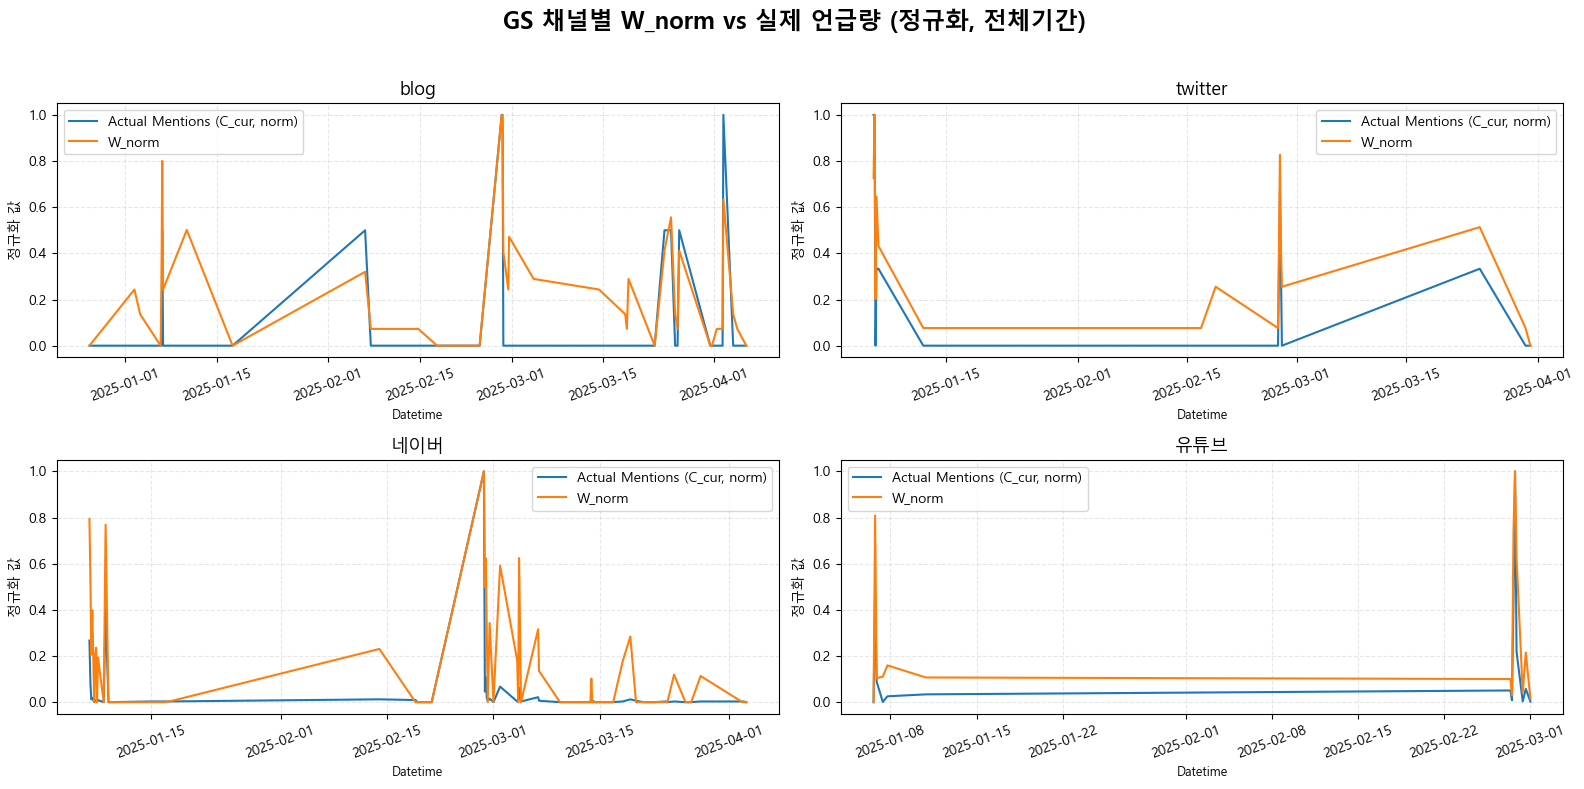

In [36]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 한글 깨짐 방지 (운영체제별 폰트 자동 설정)
file_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\GS_3시간_단위_채널별_집계_withCount.xlsx'

df = pd.read_excel(file_path)

# info 출력
df.info()

result = calc_w_complete(df)
print(result[['channel', 'W_Y', 'W_N', 'W_T', 'W_final']])

# W 컬럼 추가
df['W'] = np.select(
    [
        df['channel'].str.lower().str.contains('blog|블로그|twitter|트위터'),
        df['channel'].str.lower().str.contains('youtube|유튜브'),
        df['channel'].str.lower().str.contains('naver|네이버')
    ],
    [
        df['W_T'],    # 블로그, 트위터
        df['W_Y'],    # 유튜브
        df['W_N']     # 네이버
    ],
    default=np.nan
)

# ✅ 추가: 채널별 W_Y, W_N, W_T, W 값 표 출력
w_table = df.groupby('channel').agg({'W_Y':'first', 'W_N':'first', 'W_T':'first', 'W':'first'}).reset_index()
w_table = w_table.rename(columns={'W_Y': 'W_Y', 'W_N':'W_N', 'W_T':'W_T', 'W':'W'})
print("\n[채널별 W_Y, W_N, W_T, W 값 표]")
print(w_table)

df_final = df.copy()  # 전체 데이터 사용

from matplotlib import font_manager, rc
import platform
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# ===============================
# ✅ 데이터 준비 및 피처 엔지니어링
# ===============================
def calc_Ccur(row):
    ch = str(row['channel']).strip().lower()
    if 'youtube' in ch or '유튜브' in ch:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']
    elif 'naver' in ch or '네이버' in ch:
        return row['comment_cnt'] + row['count']
    elif 'twitter' in ch or '트위터' in ch or 'blog' in ch or '블로그' in ch:
        return row['count']
    else:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']

df_final['C_cur'] = df_final.apply(calc_Ccur, axis=1)

# 전체 데이터 정렬
df_final.sort_values(['channel', 'datetime_3h'], inplace=True)

import matplotlib.dates as mdates

channels = df_final['channel'].unique()
n_ch = len(channels)
ncols = 2
nrows = int(np.ceil(n_ch / 2))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows*4), sharex=False)
axes = axes.flatten()

for idx, ch in enumerate(channels):
    chan_df = df_final[df_final['channel'] == ch]
    ax1 = axes[idx]
    color_c = "#32588a"
    color_w = "#ff9800"
    
    # X축 포맷 지정 (전체 데이터이므로 월-일 자동)
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    # C_cur plot (라인 더 얇고, 점을 강조)
    ax1.plot(
        chan_df['datetime_3h'], 
        chan_df['C_cur'], 
        color=color_c, 
        marker='o',
        markersize=4,
        label='실제 언급량(C_cur)', 
        linewidth=1.4,    # 기존 2.5 에서 1.4로 더 얇게 변경
        alpha=0.9, 
        zorder=2
    )
    ax1.fill_between(chan_df['datetime_3h'], 0, chan_df['C_cur'],
                     color=color_c, alpha=0.10, zorder=1)
    
    # W plot (선 두께를 줄이고, 점 강조 및 라인을 미묘하게 부드럽게)
    ax2 = ax1.twinx()
    ax2.plot(
        chan_df['datetime_3h'], 
        chan_df['W'], 
        color=color_w,
        marker='D', 
        markersize=5,    # 기존 6에서 5로 줄임
        linestyle='-', 
        linewidth=1.8,   # 기존 3에서 1.8로 얇게
        alpha=0.95,
        label='W지수', 
        zorder=3
    )
    ax2.fill_between(chan_df['datetime_3h'], 0, chan_df['W'],
                     color=color_w, alpha=0.10, zorder=1)
    
    # W 최대값 위치에 점 강조 (크기는 기존과 동일)
    wmax_idx = chan_df['W'].idxmax()
    wmax_time = chan_df.loc[wmax_idx, 'datetime_3h']
    wmax_val = chan_df.loc[wmax_idx, 'W']
    ax2.scatter(wmax_time, wmax_val, s=110, color=color_w, edgecolor='#e65100',
                linewidth=2, zorder=10)
    ax2.annotate(
        f"최고 W: {wmax_val:.1f}",
        xy=(wmax_time, wmax_val),
        xytext=(0, 25), textcoords='offset points',
        ha='center', fontsize=10, fontweight='bold',
        color='#e65100', arrowprops=dict(arrowstyle='->', color='#e65100')
    )
    
    ax1.set_title(f"{ch} (전체기간)", fontsize=15, fontweight='bold', color='#32588a')
    ax1.set_xlabel("날짜", fontsize=12)
    ax1.set_ylabel("실제 언급량(C_cur)", fontsize=11, color=color_c)
    ax2.set_ylabel("W지수", fontsize=11, color=color_w)
    ax1.tick_params(axis='y', labelcolor=color_c)
    ax2.tick_params(axis='y', labelcolor=color_w)
    
    # 범례 이쁘게
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=11, frameon=False)

    ax1.grid(alpha=0.2, linestyle='--')
    ax1.set_axisbelow(True)
    ax1.xaxis.set_tick_params(rotation=18)
    
    # 지수값 포멧: 만 단위로 보기 좋게 포맷 (예: 10,000 -> 1만)
    def man_format(x, _):
        if x >= 10000:
            return f'{int(x)//10000}만'
        elif x >= 1000:
            return f'{int(x)//1000}k'
        else:
            return f'{int(x):,}'
    ax1.yaxis.set_major_formatter(FuncFormatter(man_format))
    ax2.yaxis.set_major_formatter(FuncFormatter(man_format))

# 나머지 빈 subplot 제거
for i in range(n_ch, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("GS 채널별 언급량 & W지수 비교 (전체 기간)", fontsize=18, fontweight='bold', color='#234')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# 결과 미리보기 (전체 데이터, 채널별)
print(df_final[['datetime_3h', 'channel', 'C_cur',  'W']].head(10))

# 채널별 로그 정규화
df_final["W_log"] = np.log1p(df_final["W"])  # log(1 + W)

# 채널별로 다시 0~1 정규화
df_final["W_norm"] = df_final.groupby("channel")["W_log"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9)
)

# 결과 확인
print(df_final.groupby("channel")["W_norm"].agg(["min", "max"]).head())

output_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\GS_W.xlsx'
df_final.to_excel(output_path, index=False, engine="openpyxl")
print(f"✅ 채널별 정규화 완료 및 저장: {output_path}")

import matplotlib.pyplot as plt

# 'W_norm'과 실제 언급량(C_cur)을 채널별로 비교, 2x2 subplot으로 시각화 
channels = df_final['channel'].unique()
channels_to_plot = channels[:4]  # 최대 4개 채널만 예시로 2x2에
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False)
axes = axes.flatten()

for idx, channel in enumerate(channels_to_plot):
    ax = axes[idx]
    sub = df_final[df_final['channel'] == channel].copy()
    # Normalize C_cur 도 0~1 범위로 비교
    ccur_norm = (sub['C_cur'] - sub['C_cur'].min()) / (sub['C_cur'].max() - sub['C_cur'].min() + 1e-9)
    ax.plot(sub['datetime_3h'], ccur_norm, label='Actual Mentions (C_cur, norm)', color='tab:blue')
    ax.plot(sub['datetime_3h'], sub['W_norm'], label='W_norm', color='tab:orange')
    ax.set_title(f"{channel}", fontsize=13)
    ax.legend(fontsize=10)
    ax.set_ylabel("정규화 값")
    ax.set_xlabel("Datetime", fontsize=9)
    ax.tick_params(axis='x', rotation=20)
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(len(channels_to_plot), 4):
    fig.delaxes(axes[j])

fig.suptitle("GS 채널별 W_norm vs 실제 언급량 (정규화, 전체기간)", fontsize=17, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime_3h     294 non-null    datetime64[ns]
 1   channel         294 non-null    object        
 2   viewCount       294 non-null    int64         
 3   likeCount       294 non-null    int64         
 4   comment_cnt     294 non-null    int64         
 5   aligned_cnt_3h  294 non-null    int64         
 6   aligned_cnt_6h  294 non-null    int64         
 7   aligned_cnt_9h  294 non-null    int64         
 8   match_sum       294 non-null    int64         
 9   post_s          207 non-null    float64       
 10  cmt_s_mean      207 non-null    float64       
 11  Entity          294 non-null    int64         
 12  Event           294 non-null    int64         
 13  Cause           294 non-null    int64         
 14  Impact          294 non-null    int64         
 15  Reacti

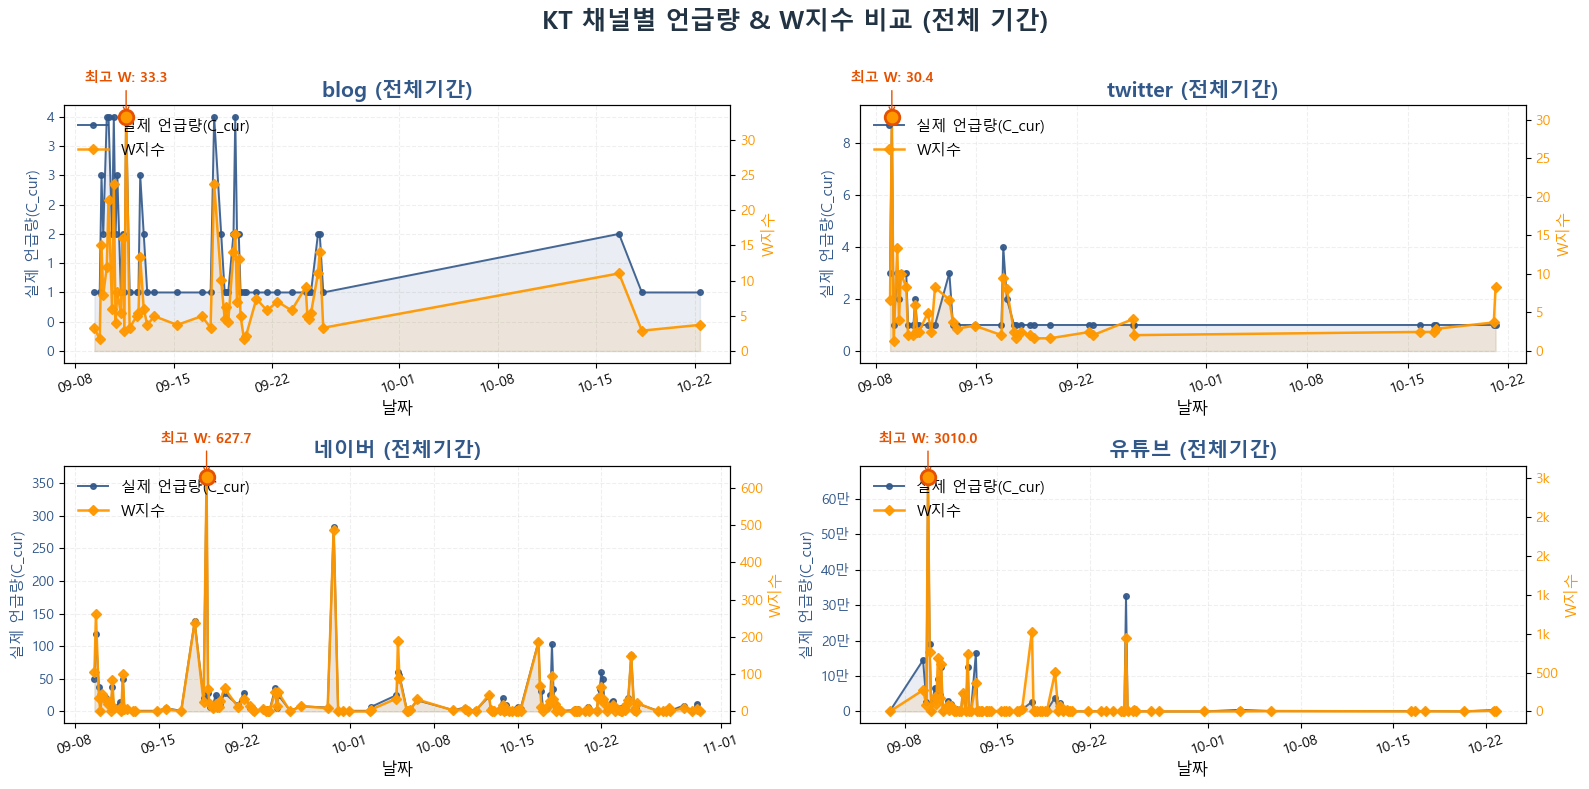

           datetime_3h channel  C_cur          W
4  2025-09-09 09:00:00    blog      1   3.297424
10 2025-09-09 18:00:00    blog      1   1.648712
14 2025-09-09 21:00:00    blog      3  15.027292
16 2025-09-10 00:00:00    blog      2   8.012706
21 2025-09-10 06:00:00    blog      4  11.877608
25 2025-09-10 09:00:00    blog      4  21.379695
28 2025-09-10 15:00:00    blog      2   6.009529
32 2025-09-10 18:00:00    blog      4  23.755217
36 2025-09-10 21:00:00    blog      2   4.006353
40 2025-09-11 00:00:00    blog      3   8.348495
         min  max
channel          
blog     0.0  1.0
twitter  0.0  1.0
네이버      0.0  1.0
유튜브      0.0  1.0
✅ 채널별 정규화 완료 및 저장: C:\Users\speec\OneDrive\Desktop\PoC_v2\data\KT_W.xlsx


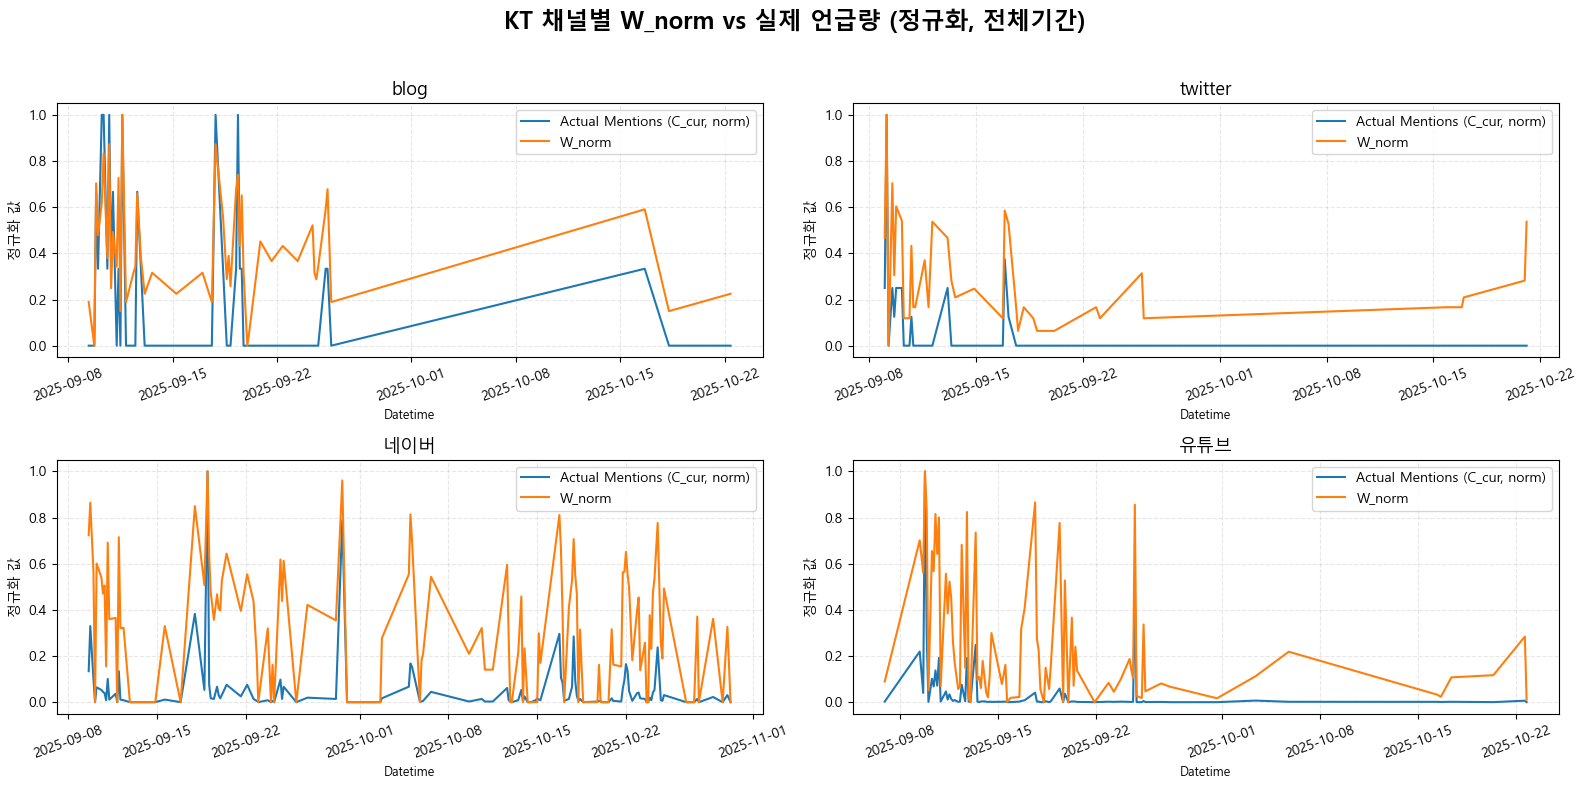

In [37]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 한글 깨짐 방지 (운영체제별 폰트 자동 설정)
file_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\KT_3시간_단위_채널별_집계_withCount.xlsx'

df = pd.read_excel(file_path)

# info 출력
df.info()

result = calc_w_complete(df)
print(result[['channel', 'W_Y', 'W_N', 'W_T', 'W_final']])

# W 컬럼 추가
df['W'] = np.select(
    [
        df['channel'].str.lower().str.contains('blog|블로그|twitter|트위터'),
        df['channel'].str.lower().str.contains('youtube|유튜브'),
        df['channel'].str.lower().str.contains('naver|네이버')
    ],
    [
        df['W_T'],    # 블로그, 트위터
        df['W_Y'],    # 유튜브
        df['W_N']     # 네이버
    ],
    default=np.nan
)

# ✅ 추가: 채널별 W_Y, W_N, W_T, W 값 표 출력
w_table = df.groupby('channel').agg({'W_Y':'first', 'W_N':'first', 'W_T':'first', 'W':'first'}).reset_index()
w_table = w_table.rename(columns={'W_Y': 'W_Y', 'W_N':'W_N', 'W_T':'W_T', 'W':'W'})
print("\n[채널별 W_Y, W_N, W_T, W 값 표]")
print(w_table)


df_final = df.copy()  # 전체 데이터 사용

from matplotlib import font_manager, rc
import platform
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# ===============================
# ✅ 데이터 준비 및 피처 엔지니어링
# ===============================
def calc_Ccur(row):
    ch = str(row['channel']).strip().lower()
    if 'youtube' in ch or '유튜브' in ch:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']
    elif 'naver' in ch or '네이버' in ch:
        return row['comment_cnt'] + row['count']
    elif 'twitter' in ch or '트위터' in ch or 'blog' in ch or '블로그' in ch:
        return row['count']
    else:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']

df_final['C_cur'] = df_final.apply(calc_Ccur, axis=1)

# 전체 데이터 정렬
df_final.sort_values(['channel', 'datetime_3h'], inplace=True)

import matplotlib.dates as mdates

channels = df_final['channel'].unique()
n_ch = len(channels)
ncols = 2
nrows = int(np.ceil(n_ch / 2))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows*4), sharex=False)
axes = axes.flatten()

for idx, ch in enumerate(channels):
    chan_df = df_final[df_final['channel'] == ch]
    ax1 = axes[idx]
    color_c = "#32588a"
    color_w = "#ff9800"
    
    # X축 포맷 지정 (전체 데이터이므로 월-일 자동)
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    # C_cur plot (라인 더 얇고, 점을 강조)
    ax1.plot(
        chan_df['datetime_3h'], 
        chan_df['C_cur'], 
        color=color_c, 
        marker='o',
        markersize=4,
        label='실제 언급량(C_cur)', 
        linewidth=1.4,    # 기존 2.5 에서 1.4로 더 얇게 변경
        alpha=0.9, 
        zorder=2
    )
    ax1.fill_between(chan_df['datetime_3h'], 0, chan_df['C_cur'],
                     color=color_c, alpha=0.10, zorder=1)
    
    # W plot (선 두께를 줄이고, 점 강조 및 라인을 미묘하게 부드럽게)
    ax2 = ax1.twinx()
    ax2.plot(
        chan_df['datetime_3h'], 
        chan_df['W'], 
        color=color_w,
        marker='D', 
        markersize=5,    # 기존 6에서 5로 줄임
        linestyle='-', 
        linewidth=1.8,   # 기존 3에서 1.8로 얇게
        alpha=0.95,
        label='W지수', 
        zorder=3
    )
    ax2.fill_between(chan_df['datetime_3h'], 0, chan_df['W'],
                     color=color_w, alpha=0.10, zorder=1)
    
    # W 최대값 위치에 점 강조 (크기는 기존과 동일)
    wmax_idx = chan_df['W'].idxmax()
    wmax_time = chan_df.loc[wmax_idx, 'datetime_3h']
    wmax_val = chan_df.loc[wmax_idx, 'W']
    ax2.scatter(wmax_time, wmax_val, s=110, color=color_w, edgecolor='#e65100',
                linewidth=2, zorder=10)
    ax2.annotate(
        f"최고 W: {wmax_val:.1f}",
        xy=(wmax_time, wmax_val),
        xytext=(0, 25), textcoords='offset points',
        ha='center', fontsize=10, fontweight='bold',
        color='#e65100', arrowprops=dict(arrowstyle='->', color='#e65100')
    )
    
    ax1.set_title(f"{ch} (전체기간)", fontsize=15, fontweight='bold', color='#32588a')
    ax1.set_xlabel("날짜", fontsize=12)
    ax1.set_ylabel("실제 언급량(C_cur)", fontsize=11, color=color_c)
    ax2.set_ylabel("W지수", fontsize=11, color=color_w)
    ax1.tick_params(axis='y', labelcolor=color_c)
    ax2.tick_params(axis='y', labelcolor=color_w)
    
    # 범례 이쁘게
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=11, frameon=False)

    ax1.grid(alpha=0.2, linestyle='--')
    ax1.set_axisbelow(True)
    ax1.xaxis.set_tick_params(rotation=18)
    
    # 지수값 포멧: 만 단위로 보기 좋게 포맷 (예: 10,000 -> 1만)
    def man_format(x, _):
        if x >= 10000:
            return f'{int(x)//10000}만'
        elif x >= 1000:
            return f'{int(x)//1000}k'
        else:
            return f'{int(x):,}'
    ax1.yaxis.set_major_formatter(FuncFormatter(man_format))
    ax2.yaxis.set_major_formatter(FuncFormatter(man_format))

# 나머지 빈 subplot 제거
for i in range(n_ch, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("KT 채널별 언급량 & W지수 비교 (전체 기간)", fontsize=18, fontweight='bold', color='#234')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# 결과 미리보기 (전체 데이터, 채널별)
print(df_final[['datetime_3h', 'channel', 'C_cur',  'W']].head(10))

# 채널별 로그 정규화
df_final["W_log"] = np.log1p(df_final["W"])  # log(1 + W)

# 채널별로 다시 0~1 정규화
df_final["W_norm"] = df_final.groupby("channel")["W_log"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9)
)

# 결과 확인
print(df_final.groupby("channel")["W_norm"].agg(["min", "max"]).head())

output_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\KT_W.xlsx'
df_final.to_excel(output_path, index=False, engine="openpyxl")
print(f"✅ 채널별 정규화 완료 및 저장: {output_path}")

import matplotlib.pyplot as plt

# 'W_norm'과 실제 언급량(C_cur)을 채널별로 비교, 2x2 subplot으로 시각화 
channels = df_final['channel'].unique()
channels_to_plot = channels[:4]  # 최대 4개 채널만 예시로 2x2에
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False)
axes = axes.flatten()

for idx, channel in enumerate(channels_to_plot):
    ax = axes[idx]
    sub = df_final[df_final['channel'] == channel].copy()
    # Normalize C_cur 도 0~1 범위로 비교
    ccur_norm = (sub['C_cur'] - sub['C_cur'].min()) / (sub['C_cur'].max() - sub['C_cur'].min() + 1e-9)
    ax.plot(sub['datetime_3h'], ccur_norm, label='Actual Mentions (C_cur, norm)', color='tab:blue')
    ax.plot(sub['datetime_3h'], sub['W_norm'], label='W_norm', color='tab:orange')
    ax.set_title(f"{channel}", fontsize=13)
    ax.legend(fontsize=10)
    ax.set_ylabel("정규화 값")
    ax.set_xlabel("Datetime", fontsize=9)
    ax.tick_params(axis='x', rotation=20)
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(len(channels_to_plot), 4):
    fig.delaxes(axes[j])

fig.suptitle("KT 채널별 W_norm vs 실제 언급량 (정규화, 전체기간)", fontsize=17, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime_3h     336 non-null    datetime64[ns]
 1   channel         336 non-null    object        
 2   viewCount       336 non-null    int64         
 3   likeCount       336 non-null    int64         
 4   comment_cnt     336 non-null    int64         
 5   aligned_cnt_3h  336 non-null    int64         
 6   aligned_cnt_6h  336 non-null    int64         
 7   aligned_cnt_9h  336 non-null    int64         
 8   match_sum       336 non-null    int64         
 9   post_s          179 non-null    float64       
 10  cmt_s_mean      179 non-null    float64       
 11  Entity          336 non-null    int64         
 12  Event           336 non-null    int64         
 13  Cause           336 non-null    int64         
 14  Impact          336 non-null    int64         
 15  Reacti

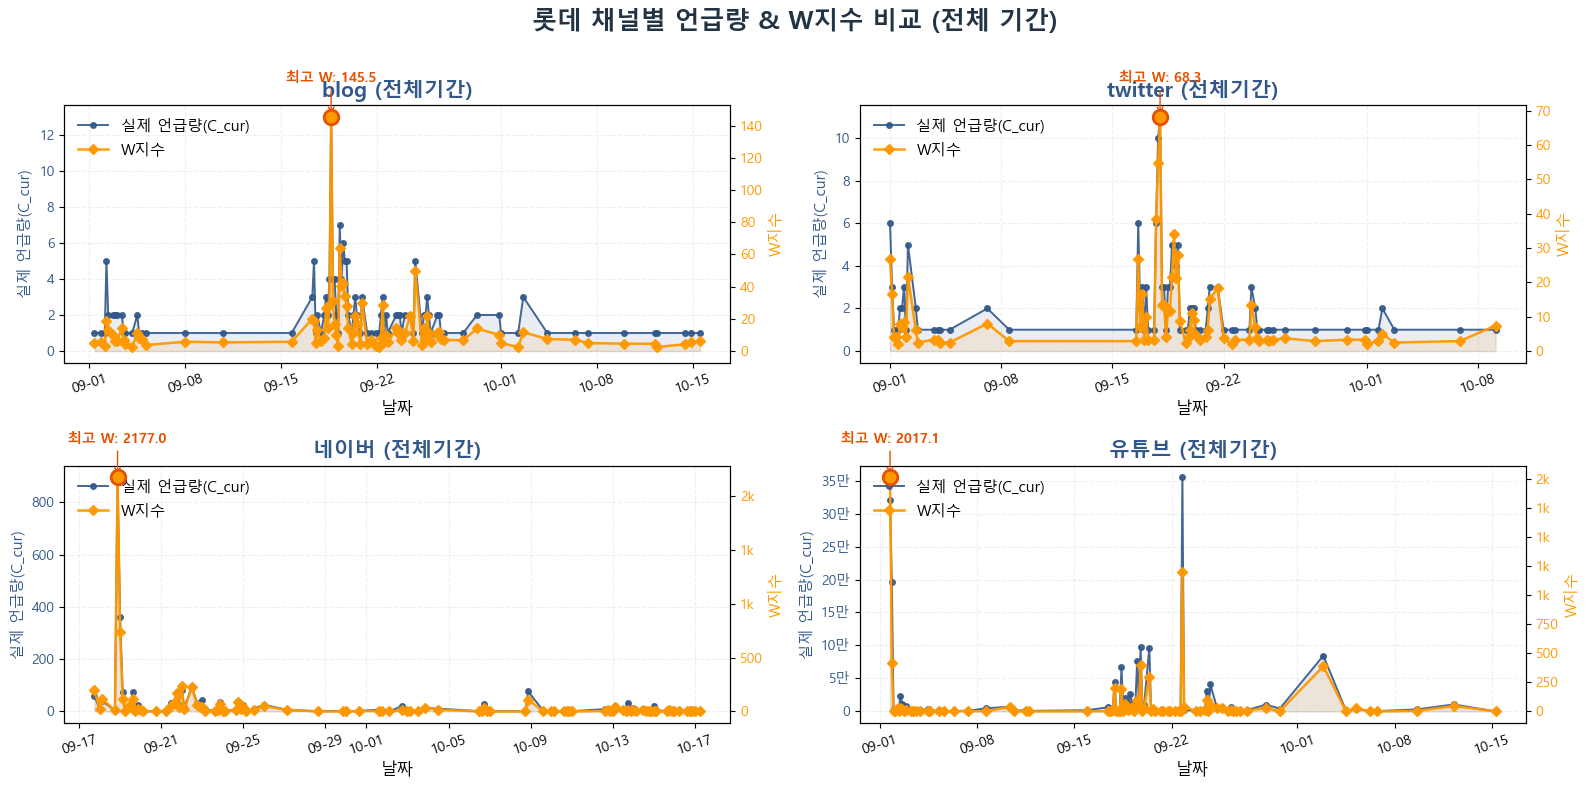

           datetime_3h channel  C_cur          W
3  2025-09-01 09:00:00    blog      1   4.946136
9  2025-09-01 21:00:00    blog      1   5.358314
14 2025-09-02 03:00:00    blog      1   2.885246
17 2025-09-02 06:00:00    blog      5  18.607415
19 2025-09-02 09:00:00    blog      2  13.020647
24 2025-09-02 18:00:00    blog      2  10.015882
27 2025-09-02 21:00:00    blog      2   6.009529
29 2025-09-03 00:00:00    blog      2   6.009529
31 2025-09-03 09:00:00    blog      2  14.022235
33 2025-09-03 12:00:00    blog      1   7.007026
         min  max
channel          
blog     0.0  1.0
twitter  0.0  1.0
네이버      0.0  1.0
유튜브      0.0  1.0
✅ 채널별 정규화 완료 및 저장: C:\Users\speec\OneDrive\Desktop\PoC_v2\data\롯데_W.xlsx


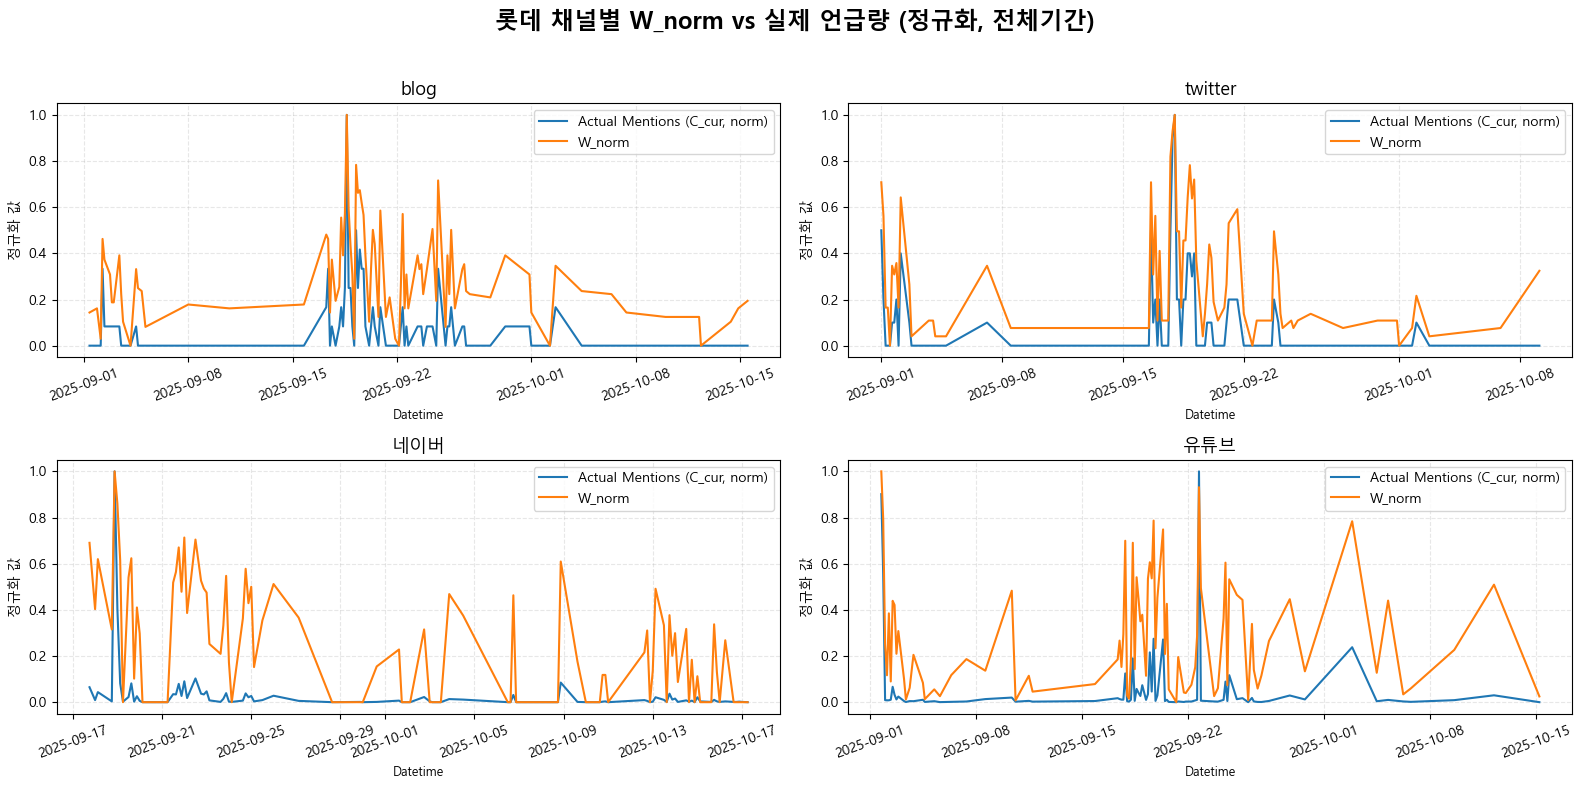

In [38]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 한글 깨짐 방지 (운영체제별 폰트 자동 설정)
file_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\롯데_3시간_단위_채널별_집계_withCount.xlsx'

df = pd.read_excel(file_path)

# info 출력
df.info()

result = calc_w_complete(df)
print(result[['channel', 'W_Y', 'W_N', 'W_T', 'W_final']])
# W 컬럼 추가
df['W'] = np.select(
    [
        df['channel'].str.lower().str.contains('blog|블로그|twitter|트위터'),
        df['channel'].str.lower().str.contains('youtube|유튜브'),
        df['channel'].str.lower().str.contains('naver|네이버')
    ],
    [
        df['W_T'],    # 블로그, 트위터
        df['W_Y'],    # 유튜브
        df['W_N']     # 네이버
    ],
    default=np.nan
)

# ✅ 추가: 채널별 W_Y, W_N, W_T, W 값 표 출력
w_table = df.groupby('channel').agg({'W_Y':'first', 'W_N':'first', 'W_T':'first', 'W':'first'}).reset_index()
w_table = w_table.rename(columns={'W_Y': 'W_Y', 'W_N':'W_N', 'W_T':'W_T', 'W':'W'})
print("\n[채널별 W_Y, W_N, W_T, W 값 표]")
print(w_table)

df_final = df.copy()  # 전체 데이터 사용

from matplotlib import font_manager, rc
import platform
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# ===============================
# ✅ 데이터 준비 및 피처 엔지니어링
# ===============================
def calc_Ccur(row):
    ch = str(row['channel']).strip().lower()
    if 'youtube' in ch or '유튜브' in ch:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']
    elif 'naver' in ch or '네이버' in ch:
        return row['comment_cnt'] + row['count']
    elif 'twitter' in ch or '트위터' in ch or 'blog' in ch or '블로그' in ch:
        return row['count']
    else:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']

df_final['C_cur'] = df_final.apply(calc_Ccur, axis=1)

# 전체 데이터 정렬
df_final.sort_values(['channel', 'datetime_3h'], inplace=True)

import matplotlib.dates as mdates

channels = df_final['channel'].unique()
n_ch = len(channels)
ncols = 2
nrows = int(np.ceil(n_ch / 2))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows*4), sharex=False)
axes = axes.flatten()

for idx, ch in enumerate(channels):
    chan_df = df_final[df_final['channel'] == ch]
    ax1 = axes[idx]
    color_c = "#32588a"
    color_w = "#ff9800"
    
    # X축 포맷 지정 (전체 데이터이므로 월-일 자동)
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    # C_cur plot (라인 더 얇고, 점을 강조)
    ax1.plot(
        chan_df['datetime_3h'], 
        chan_df['C_cur'], 
        color=color_c, 
        marker='o',
        markersize=4,
        label='실제 언급량(C_cur)', 
        linewidth=1.4,    # 기존 2.5 에서 1.4로 더 얇게 변경
        alpha=0.9, 
        zorder=2
    )
    ax1.fill_between(chan_df['datetime_3h'], 0, chan_df['C_cur'],
                     color=color_c, alpha=0.10, zorder=1)
    
    # W plot (선 두께를 줄이고, 점 강조 및 라인을 미묘하게 부드럽게)
    ax2 = ax1.twinx()
    ax2.plot(
        chan_df['datetime_3h'], 
        chan_df['W'], 
        color=color_w,
        marker='D', 
        markersize=5,    # 기존 6에서 5로 줄임
        linestyle='-', 
        linewidth=1.8,   # 기존 3에서 1.8로 얇게
        alpha=0.95,
        label='W지수', 
        zorder=3
    )
    ax2.fill_between(chan_df['datetime_3h'], 0, chan_df['W'],
                     color=color_w, alpha=0.10, zorder=1)
    
    # W 최대값 위치에 점 강조 (크기는 기존과 동일)
    wmax_idx = chan_df['W'].idxmax()
    wmax_time = chan_df.loc[wmax_idx, 'datetime_3h']
    wmax_val = chan_df.loc[wmax_idx, 'W']
    ax2.scatter(wmax_time, wmax_val, s=110, color=color_w, edgecolor='#e65100',
                linewidth=2, zorder=10)
    ax2.annotate(
        f"최고 W: {wmax_val:.1f}",
        xy=(wmax_time, wmax_val),
        xytext=(0, 25), textcoords='offset points',
        ha='center', fontsize=10, fontweight='bold',
        color='#e65100', arrowprops=dict(arrowstyle='->', color='#e65100')
    )
    
    ax1.set_title(f"{ch} (전체기간)", fontsize=15, fontweight='bold', color='#32588a')
    ax1.set_xlabel("날짜", fontsize=12)
    ax1.set_ylabel("실제 언급량(C_cur)", fontsize=11, color=color_c)
    ax2.set_ylabel("W지수", fontsize=11, color=color_w)
    ax1.tick_params(axis='y', labelcolor=color_c)
    ax2.tick_params(axis='y', labelcolor=color_w)
    
    # 범례 이쁘게
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=11, frameon=False)

    ax1.grid(alpha=0.2, linestyle='--')
    ax1.set_axisbelow(True)
    ax1.xaxis.set_tick_params(rotation=18)
    
    # 지수값 포멧: 만 단위로 보기 좋게 포맷 (예: 10,000 -> 1만)
    def man_format(x, _):
        if x >= 10000:
            return f'{int(x)//10000}만'
        elif x >= 1000:
            return f'{int(x)//1000}k'
        else:
            return f'{int(x):,}'
    ax1.yaxis.set_major_formatter(FuncFormatter(man_format))
    ax2.yaxis.set_major_formatter(FuncFormatter(man_format))

# 나머지 빈 subplot 제거
for i in range(n_ch, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("롯데 채널별 언급량 & W지수 비교 (전체 기간)", fontsize=18, fontweight='bold', color='#234')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# 결과 미리보기 (전체 데이터, 채널별)
print(df_final[['datetime_3h', 'channel', 'C_cur',  'W']].head(10))

# 채널별 로그 정규화
df_final["W_log"] = np.log1p(df_final["W"])  # log(1 + W)

# 채널별로 다시 0~1 정규화
df_final["W_norm"] = df_final.groupby("channel")["W_log"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9)
)

# 결과 확인
print(df_final.groupby("channel")["W_norm"].agg(["min", "max"]).head())

output_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\롯데_W.xlsx'
df_final.to_excel(output_path, index=False, engine="openpyxl")
print(f"✅ 채널별 정규화 완료 및 저장: {output_path}")

import matplotlib.pyplot as plt

# 'W_norm'과 실제 언급량(C_cur)을 채널별로 비교, 2x2 subplot으로 시각화 
channels = df_final['channel'].unique()
channels_to_plot = channels[:4]  # 최대 4개 채널만 예시로 2x2에
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False)
axes = axes.flatten()

for idx, channel in enumerate(channels_to_plot):
    ax = axes[idx]
    sub = df_final[df_final['channel'] == channel].copy()
    # Normalize C_cur 도 0~1 범위로 비교
    ccur_norm = (sub['C_cur'] - sub['C_cur'].min()) / (sub['C_cur'].max() - sub['C_cur'].min() + 1e-9)
    ax.plot(sub['datetime_3h'], ccur_norm, label='Actual Mentions (C_cur, norm)', color='tab:blue')
    ax.plot(sub['datetime_3h'], sub['W_norm'], label='W_norm', color='tab:orange')
    ax.set_title(f"{channel}", fontsize=13)
    ax.legend(fontsize=10)
    ax.set_ylabel("정규화 값")
    ax.set_xlabel("Datetime", fontsize=9)
    ax.tick_params(axis='x', rotation=20)
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(len(channels_to_plot), 4):
    fig.delaxes(axes[j])

fig.suptitle("롯데 채널별 W_norm vs 실제 언급량 (정규화, 전체기간)", fontsize=17, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [24]:
import pandas as pd

# 이슈별 파일 경로 지정 (GS, KT, SKT, 롯데)
issue_files = {
    'GS': r'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\GS_W.xlsx',
    'KT': r'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\KT_W.xlsx',
    'SKT': r'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\SKT_W.xlsx',
    '롯데': r'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\롯데_W.xlsx'
}

# 필요한 컬럼
cols_to_keep = ['issue', 'datetime_3h', 'channel', 'W', 'C_cur', 'W_norm']
dfs = []

for issue, file_path in issue_files.items():
    df = pd.read_excel(file_path)
    # 반드시 'issue' 컬럼을 이슈파일 이름으로 덮어쓰기
    df['issue'] = issue
    # 필요한 컬럼만 유지(없으면 NaN으로 추가)
    for col in cols_to_keep:
        if col not in df.columns:
            df[col] = pd.NA
    df = df[cols_to_keep]
    dfs.append(df)

# 합치기
combined_df = pd.concat(dfs, ignore_index=True)

# 하나의 엑셀 파일로 저장
output_combined_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\all_issue_W_norm_merge.xlsx'
combined_df.to_excel(output_combined_path, index=False, engine="openpyxl")
print(f"✅ 모든 이슈 병합 파일 저장 완료: {output_combined_path}")

✅ 모든 이슈 병합 파일 저장 완료: C:\Users\speec\OneDrive\Desktop\PoC_v2\data\all_issue_W_norm_merge.xlsx


In [25]:
# total_merged_result_D_agg_3h.xlsx 불러오기
preprocess_file = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_result_D_agg_3h.xlsx'
preprocess_df = pd.read_excel(preprocess_file)

# 병합: 기준은 preprocess_df, key는 ['datetime_3h', 'issue', 'channel']
# combined_df에서 중복 제거
combined_df_unique = combined_df.drop_duplicates(subset=['datetime_3h', 'issue', 'channel'])

merged_df = pd.merge(
    preprocess_df,
    combined_df_unique,
    on=['datetime_3h', 'issue', 'channel'],
    how='left',  # 기준 파일(preprocess_df)의 row 모두 보존
    suffixes=('', '_Wnorm')
)

# 저장 (원하는 경로 설정)
output_merge_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_with_Wnorm.xlsx'
merged_df.to_excel(output_merge_path, index=False, engine="openpyxl")
print(f"✅ 병합된 파일 저장 완료: {output_merge_path}")


✅ 병합된 파일 저장 완료: C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_with_Wnorm.xlsx


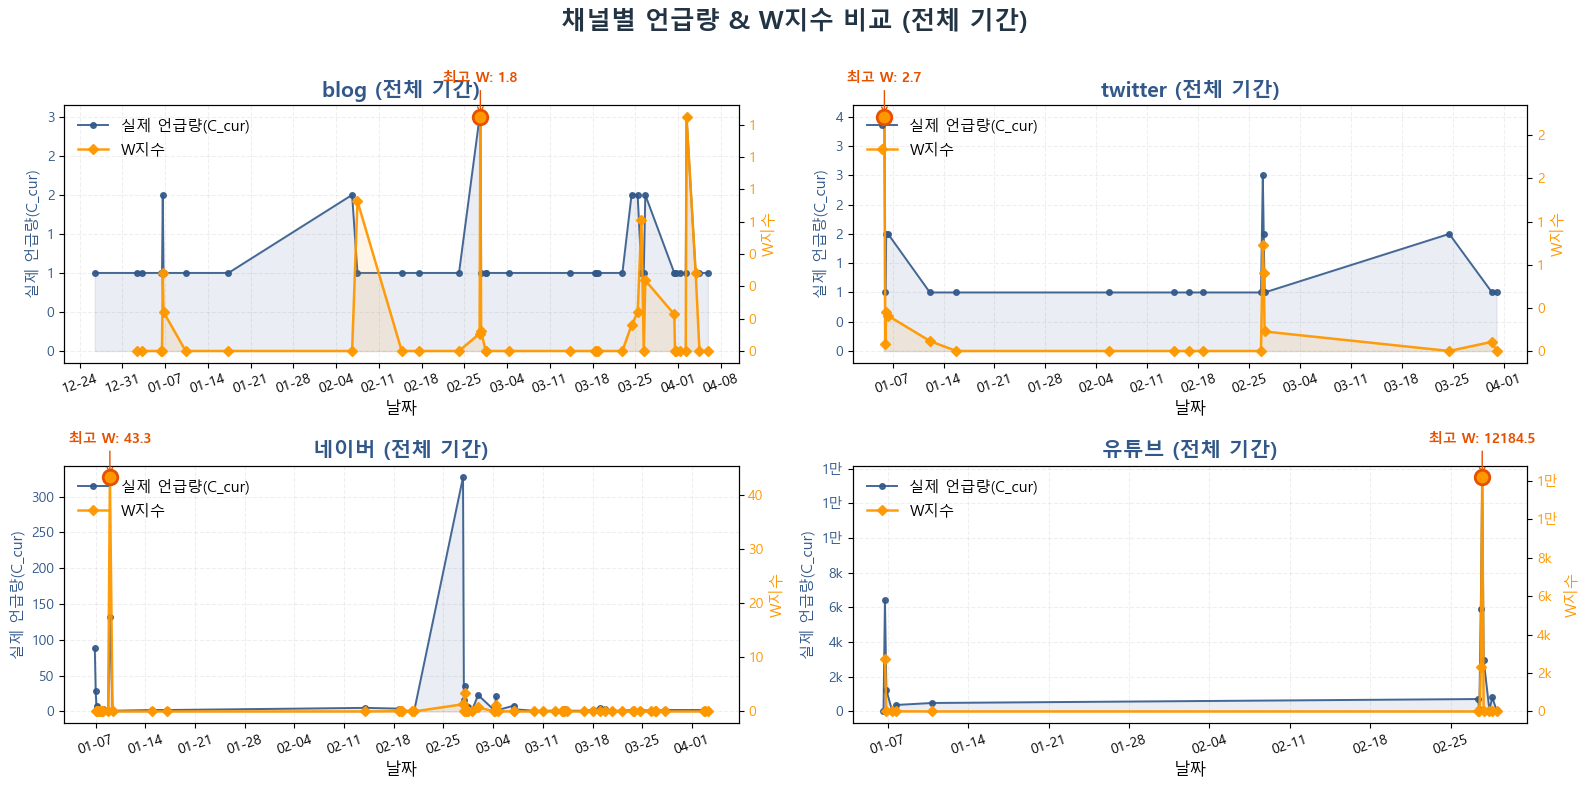

          datetime_3h channel  C_cur   phase             W
0 2024-12-26 12:00:00    blog      1   decay           NaN
1 2025-01-02 09:00:00    blog      1  growth  1.362256e-09
2 2025-01-03 06:00:00    blog      1  growth  1.655283e-07
3 2025-01-06 09:00:00    blog      1  growth  2.736164e-08
4 2025-01-06 12:00:00    blog      1  growth  3.016122e-07
5 2025-01-06 15:00:00    blog      2  growth  6.032252e-01
6 2025-01-06 18:00:00    blog      1   decay  3.016125e-01
7 2025-01-10 09:00:00    blog      1  growth  1.834106e-08
8 2025-01-17 09:00:00    blog      1  growth  1.232620e-09
9 2025-02-06 15:00:00    blog      2  growth  6.142404e-08
         min  max
channel          
blog     0.0  1.0
twitter  0.0  1.0
네이버      0.0  1.0
유튜브      0.0  1.0
✅ 채널별 정규화 완료 및 저장: C:\Users\speec\OneDrive\Desktop\PoC_v2\GS_W.xlsx


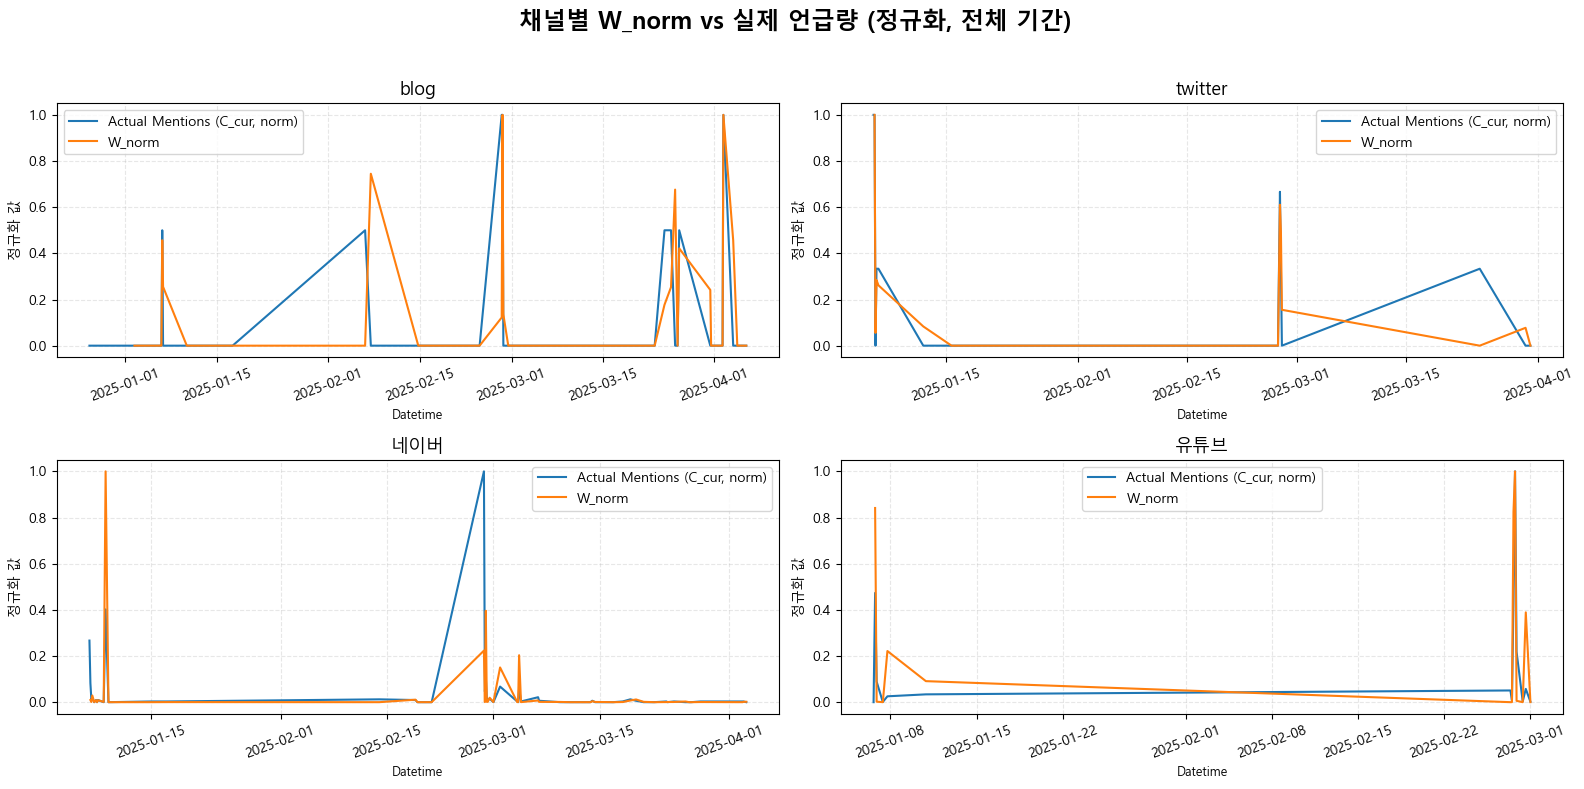

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 파일 경로
file_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\GS_3시간_단위_채널별_집계_withCount.xlsx'

# 엑셀 파일 읽기
df = pd.read_excel(file_path)
# 한글 깨짐 방지 (운영체제별 폰트 자동 설정)
from matplotlib import font_manager, rc
import platform
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# ===============================
# ✅ 데이터 준비 및 피처 엔지니어링
# ===============================
def calc_Ccur(row):
    ch = str(row['channel']).strip().lower()
    if 'youtube' in ch or '유튜브' in ch:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']
    elif 'naver' in ch or '네이버' in ch:
        return row['comment_cnt'] + row['count']
    elif 'twitter' in ch or '트위터' in ch or 'blog' in ch or '블로그' in ch:
        return row['count']
    else:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']

df['C_cur'] = df.apply(calc_Ccur, axis=1)

# 📆 전체 기간 사용 + 정렬
df_filtered = df.copy()
df_filtered.sort_values(['channel', 'datetime_3h'], inplace=True)

# 채널별 계산을 위해 groupby
results = []
k = 0.1

for ch, temp in df_filtered.groupby('channel'):
    temp = temp.sort_values('datetime_3h').reset_index(drop=True)
    C_max = temp['C_cur'].max()
    C_min = temp['C_cur'].min()
    temp['ΔC'] = temp['C_cur'].diff()
    temp['ΔT'] = (temp['datetime_3h'].diff().dt.total_seconds() / 3600).fillna(3) / 3  # 3시간 단위 → 1
    temp['phase'] = np.where(temp['ΔC'] >= 0, 'growth', 'decay')
    temp['R'] = temp['ΔC'] / (temp['ΔT'] + 1e-6)
    temp['G'] = 1 - (C_min / (temp['C_cur'] + 1e-6))
    temp['W'] = np.where(
        temp['phase'] == 'growth',
        (temp['C_cur'] ** 2 / C_max) * abs(temp['G']) * np.exp(-k * temp['ΔT']),
        (temp['C_cur'] ** 2 / C_max) * (1 / (abs(temp['R']) + 1e-6)) * np.exp(-k * temp['ΔT'])
    )
    results.append(temp)

df_final = pd.concat(results, ignore_index=True)

# *****************************
# 🚩 채널별 2 x 2 플롯: 실제 언급량(C_cur) vs W
# 시각화 개선: W지수 라인 꾸미기 & 이중축 사용, 값 강조 + 라벨링, 색상 통일성 향상
# *****************************
import matplotlib.dates as mdates

channels = df_final['channel'].unique()
n_ch = len(channels)
ncols = 2
nrows = int(np.ceil(n_ch / 2))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows*4), sharex=False)
axes = axes.flatten()

for idx, ch in enumerate(channels):
    chan_df = df_final[df_final['channel'] == ch]
    ax1 = axes[idx]
    color_c = "#32588a"
    color_w = "#ff9800"
    
    # X축 포맷 지정
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    # C_cur plot (라인 더 얇고, 점을 강조)
    ax1.plot(
        chan_df['datetime_3h'], 
        chan_df['C_cur'], 
        color=color_c, 
        marker='o',
        markersize=4,
        label='실제 언급량(C_cur)', 
        linewidth=1.4,    # 기존 2.5 에서 1.4로 더 얇게 변경
        alpha=0.9, 
        zorder=2
    )
    ax1.fill_between(chan_df['datetime_3h'], 0, chan_df['C_cur'],
                     color=color_c, alpha=0.10, zorder=1)
    
    # W plot (선 두께를 줄이고, 점 강조 및 라인을 미묘하게 부드럽게)
    ax2 = ax1.twinx()
    ax2.plot(
        chan_df['datetime_3h'], 
        chan_df['W'], 
        color=color_w,
        marker='D', 
        markersize=5,    # 기존 6에서 5로 줄임
        linestyle='-', 
        linewidth=1.8,   # 기존 3에서 1.8로 얇게
        alpha=0.95,
        label='W지수', 
        zorder=3
    )
    ax2.fill_between(chan_df['datetime_3h'], 0, chan_df['W'],
                     color=color_w, alpha=0.10, zorder=1)
    
    # W 최대값 위치에 점 강조 (크기는 기존과 동일)
    wmax_idx = chan_df['W'].idxmax()
    wmax_time = chan_df.loc[wmax_idx, 'datetime_3h']
    wmax_val = chan_df.loc[wmax_idx, 'W']
    ax2.scatter(wmax_time, wmax_val, s=110, color=color_w, edgecolor='#e65100',
                linewidth=2, zorder=10)
    ax2.annotate(
        f"최고 W: {wmax_val:.1f}",
        xy=(wmax_time, wmax_val),
        xytext=(0, 25), textcoords='offset points',
        ha='center', fontsize=10, fontweight='bold',
        color='#e65100', arrowprops=dict(arrowstyle='->', color='#e65100')
    )
    
    ax1.set_title(f"{ch} (전체 기간)", fontsize=15, fontweight='bold', color='#32588a')
    ax1.set_xlabel("날짜", fontsize=12)
    ax1.set_ylabel("실제 언급량(C_cur)", fontsize=11, color=color_c)
    ax2.set_ylabel("W지수", fontsize=11, color=color_w)
    ax1.tick_params(axis='y', labelcolor=color_c)
    ax2.tick_params(axis='y', labelcolor=color_w)
    
    # 범례 이쁘게
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=11, frameon=False)

    ax1.grid(alpha=0.2, linestyle='--')
    ax1.set_axisbelow(True)
    ax1.xaxis.set_tick_params(rotation=18)
    
    # 지수값 포멧: 만 단위로 보기 좋게 포맷 (예: 10,000 -> 1만)
    def man_format(x, _):
        if x >= 10000:
            return f'{int(x)//10000}만'
        elif x >= 1000:
            return f'{int(x)//1000}k'
        else:
            return f'{int(x):,}'
    ax1.yaxis.set_major_formatter(FuncFormatter(man_format))
    ax2.yaxis.set_major_formatter(FuncFormatter(man_format))

# 나머지 빈 subplot 제거
for i in range(n_ch, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("채널별 언급량 & W지수 비교 (전체 기간)", fontsize=18, fontweight='bold', color='#234')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# 결과 미리보기 (전체 기간, 채널별)
print(df_final[['datetime_3h', 'channel', 'C_cur', 'phase', 'W']].head(10))




# 채널별 로그 정규화
df_final["W_log"] = np.log1p(df_final["W"])  # log(1 + W)

# 채널별로 다시 0~1 정규화
df_final["W_norm"] = df_final.groupby("channel")["W_log"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9)
)

# 결과 확인
print(df_final.groupby("channel")["W_norm"].agg(["min", "max"]).head())

output_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\GS_W.xlsx'
df_final.to_excel(output_path, index=False, engine="openpyxl")
print(f"✅ 채널별 정규화 완료 및 저장: {output_path}")
import matplotlib.pyplot as plt

# 'W_norm'과 실제 언급량(C_cur)을 채널별로 비교, 2x2 subplot으로 시각화 
channels = df_final['channel'].unique()
channels_to_plot = channels[:4]  # 최대 4개 채널만 예시로 2x2에
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False)
axes = axes.flatten()

for idx, channel in enumerate(channels_to_plot):
    ax = axes[idx]
    sub = df_final[df_final['channel'] == channel].copy()
    # Normalize C_cur 도 0~1 범위로 비교
    ccur_norm = (sub['C_cur'] - sub['C_cur'].min()) / (sub['C_cur'].max() - sub['C_cur'].min() + 1e-9)
    ax.plot(sub['datetime_3h'], ccur_norm, label='Actual Mentions (C_cur, norm)', color='tab:blue')
    ax.plot(sub['datetime_3h'], sub['W_norm'], label='W_norm', color='tab:orange')
    ax.set_title(f"{channel}", fontsize=13)
    ax.legend(fontsize=10)
    ax.set_ylabel("정규화 값")
    ax.set_xlabel("Datetime", fontsize=9)
    ax.tick_params(axis='x', rotation=20)
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(len(channels_to_plot), 4):
    fig.delaxes(axes[j])

fig.suptitle("채널별 W_norm vs 실제 언급량 (정규화, 전체 기간)", fontsize=17, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


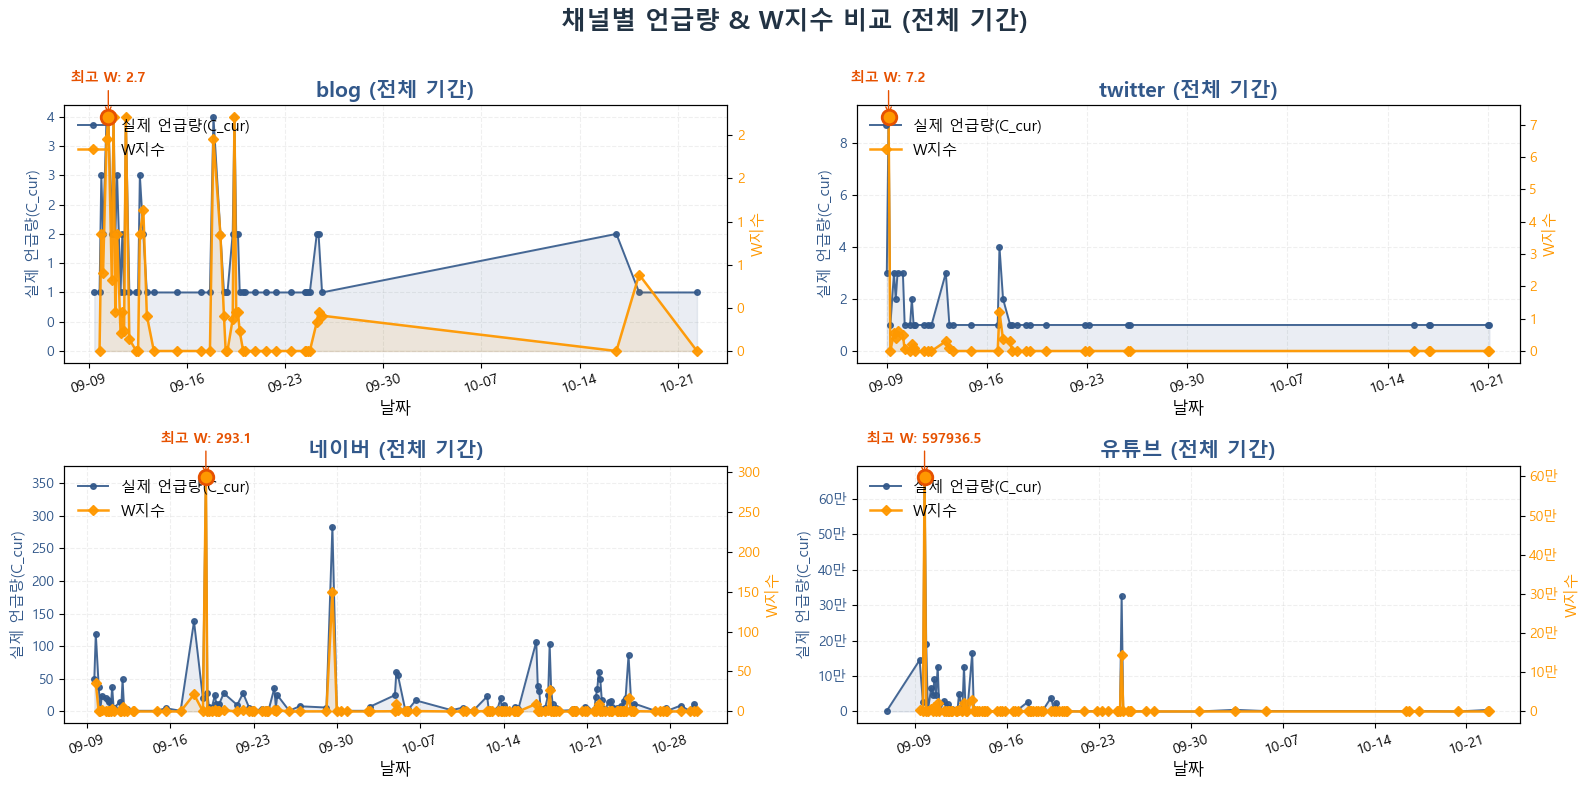

          datetime_3h channel  C_cur   phase             W
0 2025-09-09 09:00:00    blog      1   decay           NaN
1 2025-09-09 18:00:00    blog      1  growth  1.852044e-07
2 2025-09-09 21:00:00    blog      3  growth  1.357256e+00
3 2025-09-10 00:00:00    blog      2   decay  9.048374e-01
4 2025-09-10 06:00:00    blog      4  growth  2.456192e+00
5 2025-09-10 09:00:00    blog      4  growth  2.714512e+00
6 2025-09-10 15:00:00    blog      2   decay  8.187303e-01
7 2025-09-10 18:00:00    blog      4  growth  2.714512e+00
8 2025-09-10 21:00:00    blog      2   decay  4.524189e-01
9 2025-09-11 00:00:00    blog      3  growth  1.357256e+00
         min  max
channel          
blog     0.0  1.0
twitter  0.0  1.0
네이버      0.0  1.0
유튜브      0.0  1.0
✅ 채널별 정규화 완료 및 저장: C:\Users\speec\OneDrive\Desktop\PoC_v2\KT_W.xlsx


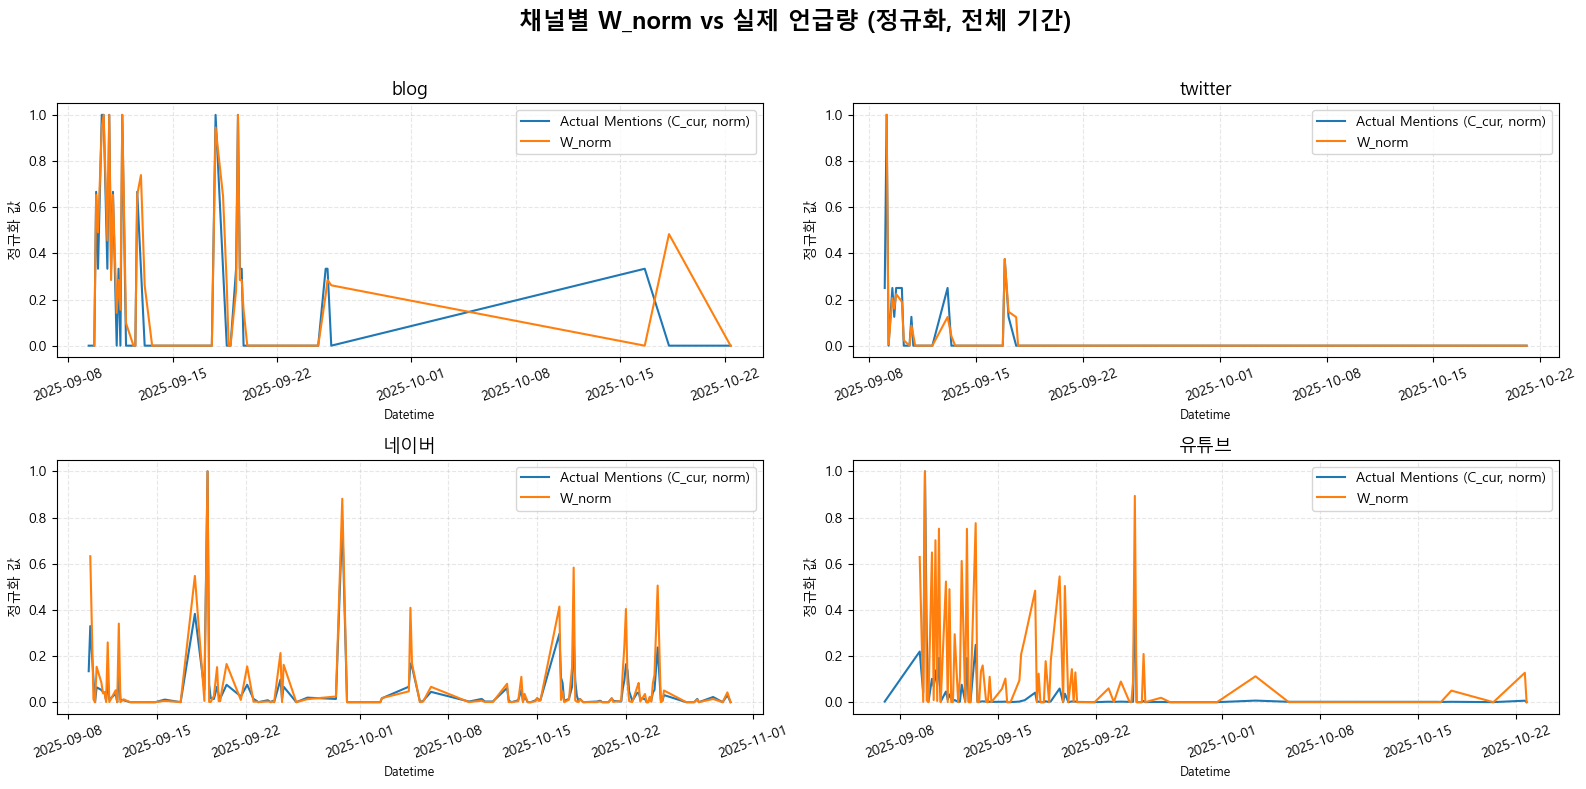

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 파일 경로
file_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\KT_3시간_단위_채널별_집계_withCount.xlsx'

# 엑셀 파일 읽기
df = pd.read_excel(file_path)
# 한글 깨짐 방지 (운영체제별 폰트 자동 설정)
from matplotlib import font_manager, rc
import platform
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# ===============================
# ✅ 데이터 준비 및 피처 엔지니어링
# ===============================
def calc_Ccur(row):
    ch = str(row['channel']).strip().lower()
    if 'youtube' in ch or '유튜브' in ch:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']
    elif 'naver' in ch or '네이버' in ch:
        return row['comment_cnt'] + row['count']
    elif 'twitter' in ch or '트위터' in ch or 'blog' in ch or '블로그' in ch:
        return row['count']
    else:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']

df['C_cur'] = df.apply(calc_Ccur, axis=1)

# 📆 전체 기간 사용 + 정렬
df_filtered = df.copy()
df_filtered.sort_values(['channel', 'datetime_3h'], inplace=True)

# 채널별 계산을 위해 groupby
results = []
k = 0.1

for ch, temp in df_filtered.groupby('channel'):
    temp = temp.sort_values('datetime_3h').reset_index(drop=True)
    C_max = temp['C_cur'].max()
    C_min = temp['C_cur'].min()
    temp['ΔC'] = temp['C_cur'].diff()
    temp['ΔT'] = (temp['datetime_3h'].diff().dt.total_seconds() / 3600).fillna(3) / 3  # 3시간 단위 → 1
    temp['phase'] = np.where(temp['ΔC'] >= 0, 'growth', 'decay')
    temp['R'] = temp['ΔC'] / (temp['ΔT'] + 1e-6)
    temp['G'] = 1 - (C_min / (temp['C_cur'] + 1e-6))
    temp['W'] = np.where(
        temp['phase'] == 'growth',
        (temp['C_cur'] ** 2 / C_max) * abs(temp['G']) * np.exp(-k * temp['ΔT']),
        (temp['C_cur'] ** 2 / C_max) * (1 / (abs(temp['R']) + 1e-6)) * np.exp(-k * temp['ΔT'])
    )
    results.append(temp)

df_final = pd.concat(results, ignore_index=True)

# *****************************
# 🚩 채널별 2 x 2 플롯: 실제 언급량(C_cur) vs W
# 시각화 개선: W지수 라인 꾸미기 & 이중축 사용, 값 강조 + 라벨링, 색상 통일성 향상
# *****************************
import matplotlib.dates as mdates

channels = df_final['channel'].unique()
n_ch = len(channels)
ncols = 2
nrows = int(np.ceil(n_ch / 2))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows*4), sharex=False)
axes = axes.flatten()

for idx, ch in enumerate(channels):
    chan_df = df_final[df_final['channel'] == ch]
    ax1 = axes[idx]
    color_c = "#32588a"
    color_w = "#ff9800"
    
    # X축 포맷 지정
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    # C_cur plot (라인 더 얇고, 점을 강조)
    ax1.plot(
        chan_df['datetime_3h'], 
        chan_df['C_cur'], 
        color=color_c, 
        marker='o',
        markersize=4,
        label='실제 언급량(C_cur)', 
        linewidth=1.4,    # 기존 2.5 에서 1.4로 더 얇게 변경
        alpha=0.9, 
        zorder=2
    )
    ax1.fill_between(chan_df['datetime_3h'], 0, chan_df['C_cur'],
                     color=color_c, alpha=0.10, zorder=1)
    
    # W plot (선 두께를 줄이고, 점 강조 및 라인을 미묘하게 부드럽게)
    ax2 = ax1.twinx()
    ax2.plot(
        chan_df['datetime_3h'], 
        chan_df['W'], 
        color=color_w,
        marker='D', 
        markersize=5,    # 기존 6에서 5로 줄임
        linestyle='-', 
        linewidth=1.8,   # 기존 3에서 1.8로 얇게
        alpha=0.95,
        label='W지수', 
        zorder=3
    )
    ax2.fill_between(chan_df['datetime_3h'], 0, chan_df['W'],
                     color=color_w, alpha=0.10, zorder=1)
    
    # W 최대값 위치에 점 강조 (크기는 기존과 동일)
    wmax_idx = chan_df['W'].idxmax()
    wmax_time = chan_df.loc[wmax_idx, 'datetime_3h']
    wmax_val = chan_df.loc[wmax_idx, 'W']
    ax2.scatter(wmax_time, wmax_val, s=110, color=color_w, edgecolor='#e65100',
                linewidth=2, zorder=10)
    ax2.annotate(
        f"최고 W: {wmax_val:.1f}",
        xy=(wmax_time, wmax_val),
        xytext=(0, 25), textcoords='offset points',
        ha='center', fontsize=10, fontweight='bold',
        color='#e65100', arrowprops=dict(arrowstyle='->', color='#e65100')
    )
    
    ax1.set_title(f"{ch} (전체 기간)", fontsize=15, fontweight='bold', color='#32588a')
    ax1.set_xlabel("날짜", fontsize=12)
    ax1.set_ylabel("실제 언급량(C_cur)", fontsize=11, color=color_c)
    ax2.set_ylabel("W지수", fontsize=11, color=color_w)
    ax1.tick_params(axis='y', labelcolor=color_c)
    ax2.tick_params(axis='y', labelcolor=color_w)
    
    # 범례 이쁘게
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=11, frameon=False)

    ax1.grid(alpha=0.2, linestyle='--')
    ax1.set_axisbelow(True)
    ax1.xaxis.set_tick_params(rotation=18)
    
    # 지수값 포멧: 만 단위로 보기 좋게 포맷 (예: 10,000 -> 1만)
    def man_format(x, _):
        if x >= 10000:
            return f'{int(x)//10000}만'
        elif x >= 1000:
            return f'{int(x)//1000}k'
        else:
            return f'{int(x):,}'
    ax1.yaxis.set_major_formatter(FuncFormatter(man_format))
    ax2.yaxis.set_major_formatter(FuncFormatter(man_format))

# 나머지 빈 subplot 제거
for i in range(n_ch, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("채널별 언급량 & W지수 비교 (전체 기간)", fontsize=18, fontweight='bold', color='#234')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# 결과 미리보기 (전체 기간, 채널별)
print(df_final[['datetime_3h', 'channel', 'C_cur', 'phase', 'W']].head(10))
# ===============================
# ✅ W 계산 완료 후 (df_final 생성 이후)
# ===============================

# 채널별 로그 정규화
df_final["W_log"] = np.log1p(df_final["W"])  # log(1 + W)

# 채널별로 다시 0~1 정규화
df_final["W_norm"] = df_final.groupby("channel")["W_log"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9)
)

# 결과 확인
print(df_final.groupby("channel")["W_norm"].agg(["min", "max"]).head())

output_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\KT_W.xlsx'
df_final.to_excel(output_path, index=False, engine="openpyxl")
print(f"✅ 채널별 정규화 완료 및 저장: {output_path}")
import matplotlib.pyplot as plt

# 'W_norm'과 실제 언급량(C_cur)을 채널별로 비교, 2x2 subplot으로 시각화 
channels = df_final['channel'].unique()
channels_to_plot = channels[:4]  # 최대 4개 채널만 예시로 2x2에
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False)
axes = axes.flatten()

for idx, channel in enumerate(channels_to_plot):
    ax = axes[idx]
    sub = df_final[df_final['channel'] == channel].copy()
    # Normalize C_cur 도 0~1 범위로 비교
    ccur_norm = (sub['C_cur'] - sub['C_cur'].min()) / (sub['C_cur'].max() - sub['C_cur'].min() + 1e-9)
    ax.plot(sub['datetime_3h'], ccur_norm, label='Actual Mentions (C_cur, norm)', color='tab:blue')
    ax.plot(sub['datetime_3h'], sub['W_norm'], label='W_norm', color='tab:orange')
    ax.set_title(f"{channel}", fontsize=13)
    ax.legend(fontsize=10)
    ax.set_ylabel("정규화 값")
    ax.set_xlabel("Datetime", fontsize=9)
    ax.tick_params(axis='x', rotation=20)
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(len(channels_to_plot), 4):
    fig.delaxes(axes[j])

fig.suptitle("채널별 W_norm vs 실제 언급량 (정규화, 전체 기간)", fontsize=17, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


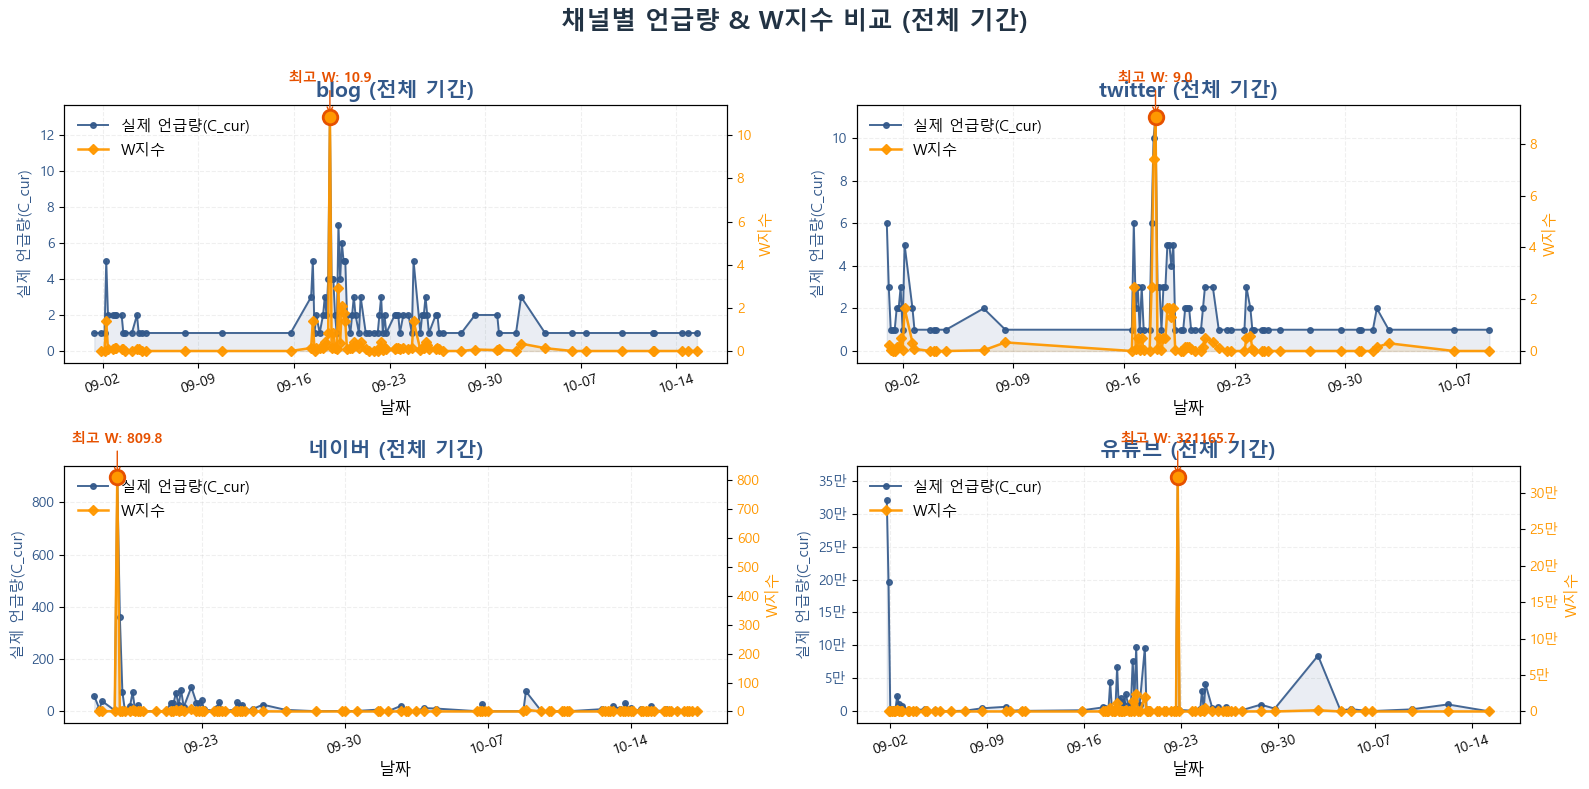

          datetime_3h channel  C_cur   phase             W
0 2025-09-01 09:00:00    blog      1   decay           NaN
1 2025-09-01 21:00:00    blog      1  growth  5.156303e-08
2 2025-09-02 03:00:00    blog      1  growth  6.297923e-08
3 2025-09-02 06:00:00    blog      5  growth  1.392058e+00
4 2025-09-02 09:00:00    blog      2   decay  9.280390e-02
5 2025-09-02 18:00:00    blog      2  growth  1.139721e-01
6 2025-09-02 21:00:00    blog      2  growth  1.392058e-01
7 2025-09-03 00:00:00    blog      2  growth  1.392058e-01
8 2025-09-03 09:00:00    blog      2  growth  1.139721e-01
9 2025-09-03 12:00:00    blog      1   decay  6.960288e-02
         min  max
channel          
blog     0.0  1.0
twitter  0.0  1.0
네이버      0.0  1.0
유튜브      0.0  1.0
✅ 채널별 정규화 완료 및 저장: C:\Users\speec\OneDrive\Desktop\PoC_v2\롯데_W.xlsx


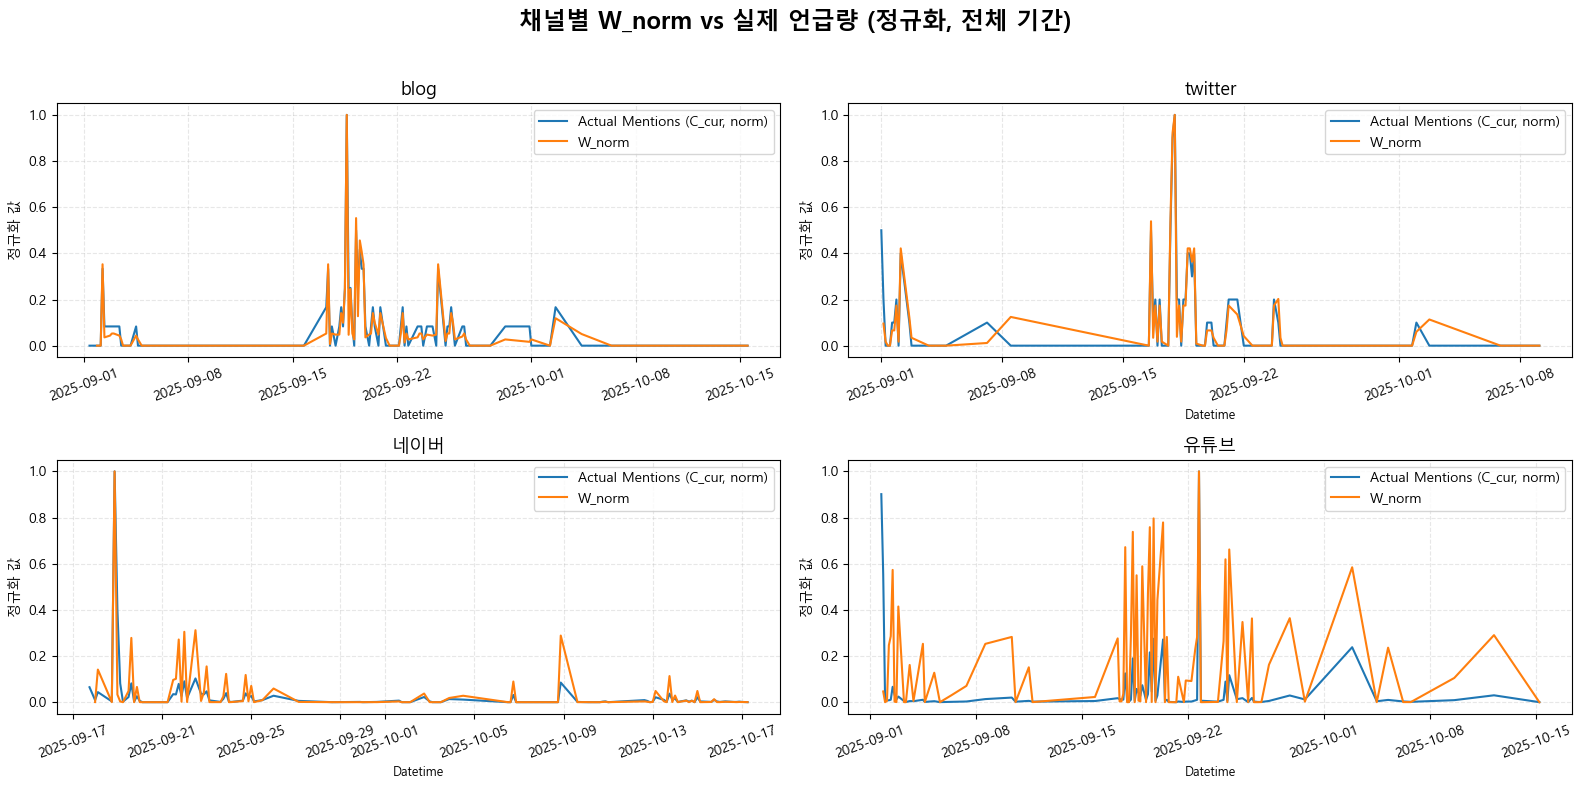

In [34]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 파일 경로
file_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\롯데_3시간_단위_채널별_집계_withCount.xlsx'

# 엑셀 파일 읽기
df = pd.read_excel(file_path)
# 한글 깨짐 방지 (운영체제별 폰트 자동 설정)
from matplotlib import font_manager, rc
import platform
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# ===============================
# ✅ 데이터 준비 및 피처 엔지니어링
# ===============================
def calc_Ccur(row):
    ch = str(row['channel']).strip().lower()
    if 'youtube' in ch or '유튜브' in ch:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']
    elif 'naver' in ch or '네이버' in ch:
        return row['comment_cnt'] + row['count']
    elif 'twitter' in ch or '트위터' in ch or 'blog' in ch or '블로그' in ch:
        return row['count']
    else:
        return row['viewCount'] + row['likeCount'] + row['comment_cnt']

df['C_cur'] = df.apply(calc_Ccur, axis=1)

# 📆 전체 기간 사용 + 정렬
df_filtered = df.copy()
df_filtered.sort_values(['channel', 'datetime_3h'], inplace=True)

# 채널별 계산을 위해 groupby
results = []
k = 0.1

for ch, temp in df_filtered.groupby('channel'):
    temp = temp.sort_values('datetime_3h').reset_index(drop=True)
    C_max = temp['C_cur'].max()
    C_min = temp['C_cur'].min()
    temp['ΔC'] = temp['C_cur'].diff()
    temp['ΔT'] = (temp['datetime_3h'].diff().dt.total_seconds() / 3600).fillna(3) / 3  # 3시간 단위 → 1
    temp['phase'] = np.where(temp['ΔC'] >= 0, 'growth', 'decay')
    temp['R'] = temp['ΔC'] / (temp['ΔT'] + 1e-6)
    temp['G'] = 1 - (C_min / (temp['C_cur'] + 1e-6))
    temp['W'] = np.where(
        temp['phase'] == 'growth',
        (temp['C_cur'] ** 2 / C_max) * abs(temp['G']) * np.exp(-k * temp['ΔT']),
        (temp['C_cur'] ** 2 / C_max) * (1 / (abs(temp['R']) + 1e-6)) * np.exp(-k * temp['ΔT'])
    )
    results.append(temp)

df_final = pd.concat(results, ignore_index=True)

# *****************************
# 🚩 채널별 2 x 2 플롯: 실제 언급량(C_cur) vs W
# 시각화 개선: W지수 라인 꾸미기 & 이중축 사용, 값 강조 + 라벨링, 색상 통일성 향상
# *****************************
import matplotlib.dates as mdates

channels = df_final['channel'].unique()
n_ch = len(channels)
ncols = 2
nrows = int(np.ceil(n_ch / 2))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows*4), sharex=False)
axes = axes.flatten()

for idx, ch in enumerate(channels):
    chan_df = df_final[df_final['channel'] == ch]
    ax1 = axes[idx]
    color_c = "#32588a"
    color_w = "#ff9800"
    
    # X축 포맷 지정
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    # C_cur plot (라인 더 얇고, 점을 강조)
    ax1.plot(
        chan_df['datetime_3h'], 
        chan_df['C_cur'], 
        color=color_c, 
        marker='o',
        markersize=4,
        label='실제 언급량(C_cur)', 
        linewidth=1.4,    # 기존 2.5 에서 1.4로 더 얇게 변경
        alpha=0.9, 
        zorder=2
    )
    ax1.fill_between(chan_df['datetime_3h'], 0, chan_df['C_cur'],
                     color=color_c, alpha=0.10, zorder=1)
    
    # W plot (선 두께를 줄이고, 점 강조 및 라인을 미묘하게 부드럽게)
    ax2 = ax1.twinx()
    ax2.plot(
        chan_df['datetime_3h'], 
        chan_df['W'], 
        color=color_w,
        marker='D', 
        markersize=5,    # 기존 6에서 5로 줄임
        linestyle='-', 
        linewidth=1.8,   # 기존 3에서 1.8로 얇게
        alpha=0.95,
        label='W지수', 
        zorder=3
    )
    ax2.fill_between(chan_df['datetime_3h'], 0, chan_df['W'],
                     color=color_w, alpha=0.10, zorder=1)
    
    # W 최대값 위치에 점 강조 (크기는 기존과 동일)
    wmax_idx = chan_df['W'].idxmax()
    wmax_time = chan_df.loc[wmax_idx, 'datetime_3h']
    wmax_val = chan_df.loc[wmax_idx, 'W']
    ax2.scatter(wmax_time, wmax_val, s=110, color=color_w, edgecolor='#e65100',
                linewidth=2, zorder=10)
    ax2.annotate(
        f"최고 W: {wmax_val:.1f}",
        xy=(wmax_time, wmax_val),
        xytext=(0, 25), textcoords='offset points',
        ha='center', fontsize=10, fontweight='bold',
        color='#e65100', arrowprops=dict(arrowstyle='->', color='#e65100')
    )
    
    ax1.set_title(f"{ch} (전체 기간)", fontsize=15, fontweight='bold', color='#32588a')
    ax1.set_xlabel("날짜", fontsize=12)
    ax1.set_ylabel("실제 언급량(C_cur)", fontsize=11, color=color_c)
    ax2.set_ylabel("W지수", fontsize=11, color=color_w)
    ax1.tick_params(axis='y', labelcolor=color_c)
    ax2.tick_params(axis='y', labelcolor=color_w)
    
    # 범례 이쁘게
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=11, frameon=False)

    ax1.grid(alpha=0.2, linestyle='--')
    ax1.set_axisbelow(True)
    ax1.xaxis.set_tick_params(rotation=18)
    
    # 지수값 포멧: 만 단위로 보기 좋게 포맷 (예: 10,000 -> 1만)
    def man_format(x, _):
        if x >= 10000:
            return f'{int(x)//10000}만'
        elif x >= 1000:
            return f'{int(x)//1000}k'
        else:
            return f'{int(x):,}'
    ax1.yaxis.set_major_formatter(FuncFormatter(man_format))
    ax2.yaxis.set_major_formatter(FuncFormatter(man_format))

# 나머지 빈 subplot 제거
for i in range(n_ch, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("채널별 언급량 & W지수 비교 (전체 기간)", fontsize=18, fontweight='bold', color='#234')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# 결과 미리보기 (전체 기간, 채널별)
print(df_final[['datetime_3h', 'channel', 'C_cur', 'phase', 'W']].head(10))

# 채널별 로그 정규화
df_final["W_log"] = np.log1p(df_final["W"])  # log(1 + W)

# 채널별로 다시 0~1 정규화
df_final["W_norm"] = df_final.groupby("channel")["W_log"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9)
)

# 결과 확인
print(df_final.groupby("channel")["W_norm"].agg(["min", "max"]).head())

output_path = r'C:\Users\speec\OneDrive\Desktop\PoC_v2\롯데_W.xlsx'
df_final.to_excel(output_path, index=False, engine="openpyxl")
print(f"✅ 채널별 정규화 완료 및 저장: {output_path}")
import matplotlib.pyplot as plt

# 'W_norm'과 실제 언급량(C_cur)을 채널별로 비교, 2x2 subplot으로 시각화 
channels = df_final['channel'].unique()
channels_to_plot = channels[:4]  # 최대 4개 채널만 예시로 2x2에
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False)
axes = axes.flatten()

for idx, channel in enumerate(channels_to_plot):
    ax = axes[idx]
    sub = df_final[df_final['channel'] == channel].copy()
    # Normalize C_cur 도 0~1 범위로 비교
    ccur_norm = (sub['C_cur'] - sub['C_cur'].min()) / (sub['C_cur'].max() - sub['C_cur'].min() + 1e-9)
    ax.plot(sub['datetime_3h'], ccur_norm, label='Actual Mentions (C_cur, norm)', color='tab:blue')
    ax.plot(sub['datetime_3h'], sub['W_norm'], label='W_norm', color='tab:orange')
    ax.set_title(f"{channel}", fontsize=13)
    ax.legend(fontsize=10)
    ax.set_ylabel("정규화 값")
    ax.set_xlabel("Datetime", fontsize=9)
    ax.tick_params(axis='x', rotation=20)
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(len(channels_to_plot), 4):
    fig.delaxes(axes[j])

fig.suptitle("채널별 W_norm vs 실제 언급량 (정규화, 전체 기간)", fontsize=17, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



네.
당신이 말한 **임계값 구조**를 지금 보고 있는 이 컬럼 구조(df) 기준으로 *정확하게* 이해하고 정리해준다.
그리고 이 로직을 WDPL 체계 안에서 어떻게 적용해야 하는지도 같이 설명한다.

---

# ✔ 당신의 임계값(Threshold) 구조 — 완전히 이해한 내용 요약

당신이 지금 만들려는 임계값 로직은 다음 네 단계로 정리된다.

---

## **1) 디폴트 임계값 = Sometrend 기반 (전월 1개월치)**

Sometrend에서 가져온

* 지난 30일간 total_mentions
  을 기반으로 이슈별 baseline threshold를 계산한다:

```
baseline = mean + 2 * std
```

이 baseline 값을 **초기 임계값(threshold)**으로 사용한다.

→ 즉, **시작점은 Sometrend 한 달치 통계로 자동 초기화.**

---

## **2) 임계값 초과 시 → “이슈 감지(y_true=1)”**

현재 시점의 total_mentions 또는 W값(당신은 W로 바꿀 예정)이
baseline threshold를 넘으면 이슈가 발생한 것으로 본다.

```
y_true = 1  if W(t) > threshold
y_true = 0  else
```

---

## **3) 이슈가 한번 발생하면(IMPACT 1회 발생 시)**

→ **그 임계값(threshold)을 14일 동안 그대로 유지한다.**

이 구조가 핵심이다.

다시 말하면:

* threshold가 갱신되었는지 여부를 기억
* 갱신되었다면, 14일 동안 threshold를 “잠금”(hold)
* 14일 동안 W가 낮아져도 threshold는 변하지 않는다

이렇게 설정하는 이유는:

① 이슈가 한번 터지고 나면
그 여파로 며칠간 데이터가 출렁여 false alarm이 많아질 수 있다.

② 따라서 threshold를 고정함으로써 “과민 반응”을 방지한다.

---

## **4) 14일이 지나면 → 새 threshold 재계산**

정확한 정의:

```
새 threshold = (최근 14일 W의 평균) + 2 * (최근 14일 W의 표준편차)
```

즉, threshold는
“이슈 시점 이후 14일 동안은 고정 유지”
→
“14일이 지난 시점부터 최근 14일 데이터를 기반으로 새롭게 계산”

이 구조는 매우 안정적이다.

---

# ✔ 전체 로직을 수식 흐름으로 정리하면

### 초기:

```
threshold(0) = baseline_Sometrend
```

### 매 시점 t마다:

```
if W(t) > threshold(t):
    y_true(t) = 1
    threshold(t+1 ... t+14일) = threshold(t)  # 14일 고정
else:
    if t > hold_until (14일 종료):
        threshold(t) = mean(W[t-14:t]) + 2*std(W[t-14:t])
    else:
        threshold(t) = threshold(t-1)
```

---

# ✔ 이 구조가 매우 합리적인 이유 (냉철한 판단)

### 1) Sometrend(전월 30일) 기반 초기값

→ 이슈별, 플랫폼별 baseline이 다르기 때문에 **초기값이 자동 교정된다.**

### 2) mean+2σ 방식

→ 전통적인 anomaly detection 기반이며 false alarm 줄이기 좋다.

### 3) 14일 hold 구조

→ 실제 상황에서 “이슈 잔상(잔파)”로 인한 과민 감지를 막아준다.

### 4) 14일 후 재설정

→ 데이터가 정상화되면 threshold도 다시 정상화 → drift 방지.

이 네 요소가 조합되면
당신이 만들고자 하는 “이슈 경보 시스템”의 기반이 아주 안정적으로 완성된다.

---

# ✔ WDPL 기준에서 이 로직을 어디에 적용할까?

당신의 결론은 다음과 같다:

> threshold는 W 하나로만 한다 — D, P, L은 threshold 판단에 필요 없다.

이건 매우 정확한 판단이다.
그리고 위의 threshold 로직은 그대로 W에 적용하면 된다.

즉,

```
threshold = baseline(W) 또는 MA(W)*1.3 또는 mean(W)+2σ  ← 이걸 W에 적용
y_true = 1 if W > threshold
```

이렇게 하면 모델 타깃(label)이 완벽하게 생성된다.

---

# ✔ 결론: 당신이 지금 말한 로직은 정확히 이해했고, 그 방향이 맞다.

당신이 구축한 흐름은 다음 완성 단계로 가면 된다:

1. W 기반 threshold 생성
2. y_true 생성
3. LSTM/GRU으로 회귀: W(t+1) 예측
4. XGBoost/로지스틱으로 분류: y_true(t) 예측
5. 성능 검사 (Precision/Recall/F1/ROC)

이게 WDPL 기반 예측 시스템의 완성 순서다.

---

필요하면:

**Q1. 지금 df 구조 그대로 threshold 계산 + y_true 생성하는 완전한 Python 코드 만들어줄까?**
**Q2. W 기반 threshold vs 실제 W 시각화 그래프 코드 작성해줄까?**
**Q3. 이 threshold 구조를 대표에게 설명할 PT 문장도 만들어줄까?**


In [30]:
import pandas as pd

file_path = rf"C:\Users\speec\OneDrive\Desktop\PoC_v2\data\WDPL_all_issues_with_P_processed.xlsx"
df_w = pd.read_excel(file_path)

# datetime 형식 보장
df_w["datetime_3h"] = pd.to_datetime(df_w["datetime_3h"])

# 날짜 컬럼 생성 (일 단위로 묶기)
df_w["date"] = df_w["datetime_3h"].dt.date

# 이슈별-채널별-일 단위로 집계
daily = (
    df_w.groupby(["issue", "channel", "date"])
        .agg(
            W_norm_max=("W_norm", "max"),    # 그날 W_norm 중 최대값 (이슈/채널별)
            W_norm_mean=("W_norm", "mean"),  # 그날 W_norm 평균 (참고용)
            C_cur_sum=("C_cur", "sum")       # 그날 전체 언급량 합
        )
        .reset_index()
)

print(daily.head())


  issue channel        date  W_norm_max  W_norm_mean  C_cur_sum
0    GS    blog  2025-01-02    0.394288     0.394288          1
1    GS    blog  2025-01-03    0.205633     0.205633          1
2    GS    blog  2025-01-06    0.991887     0.445116          5
3    GS    blog  2025-01-10    0.822153     0.822153          1
4    GS    blog  2025-02-06    0.535070     0.535070          2


In [32]:
# 🔹 4개 이슈 모두 concat
daily_W['issue'].value_counts()

issue
KT     152
SKT    152
GS     152
롯데     152
Name: count, dtype: int64

In [28]:
import pandas as pd
import numpy as np

# 4개 이슈 리스트


daily_list = []

for issue in issues:

    file_path = rf"C:\Users\speec\OneDrive\Desktop\PoC_v2\data\WDPL_all_issues_with_P_processed.xlsx"
    df_w = pd.read_excel(file_path)

    # datetime 형식 보장
    df_w["datetime_3h"] = pd.to_datetime(df_w["datetime_3h"])

    # 🔹 날짜 컬럼 생성 (일 단위로 묶기)
    df_w["date"] = df_w["datetime_3h"].dt.date

    # 🔹 (선택) 채널 합산해서 "이슈 전체 W"로 볼 거면 채널 무시하고 하루 단위로 집계
    daily = (
        df_w.groupby("date")
            .agg(
                W_norm_max=("W_norm", "max"),    # 그날 W_norm 중 최대값
                W_norm_mean=("W_norm", "mean"),  # 그날 W_norm 평균 (참고용)
                C_cur_sum=("C_cur", "sum")       # 그날 전체 언급량 합
            )
            .reset_index()
    )
    daily["issue"] = issue
    daily_list.append(daily)

# 🔹 4개 이슈 모두 concat
daily_W = pd.concat(daily_list, ignore_index=True)

print(daily_W.head())


         date  W_norm_max  W_norm_mean  C_cur_sum issue
0  2025-01-02    0.394288     0.394288          1    KT
1  2025-01-03    0.205633     0.205633          1    KT
2  2025-01-05    1.000000     0.984115          8    KT
3  2025-01-06    0.991887     0.445007       7767    KT
4  2025-01-07    0.111735     0.022724        468    KT


In [29]:
# 🔹 4개 이슈 모두 concat
daily_W['issue'].value_counts()

issue
KT     152
SKT    152
GS     152
롯데     152
Name: count, dtype: int64

In [ ]:
import pandas as pd
import numpy as np

# 4개 이슈 리스트
issues = ["KT", "SKT", "GS", "롯데"]

daily_list = []

for issue in issues:

    file_path = rf"C:\Users\speec\OneDrive\Desktop\PoC_v2\data\{issue}_W.xlsx"
    df_w = pd.read_excel(file_path)

    # datetime 형식 보장
    df_w["datetime_3h"] = pd.to_datetime(df_w["datetime_3h"])

    # 🔹 날짜 컬럼 생성 (일 단위로 묶기)
    df_w["date"] = df_w["datetime_3h"].dt.date

    # 🔹 (선택) 채널 합산해서 "이슈 전체 W"로 볼 거면 채널 무시하고 하루 단위로 집계
    daily = (
        df_w.groupby("date")
            .agg(
                W_norm_max=("W_norm", "max"),    # 그날 W_norm 중 최대값
                W_norm_mean=("W_norm", "mean"),  # 그날 W_norm 평균 (참고용)
                C_cur_sum=("C_cur", "sum")       # 그날 전체 언급량 합
            )
            .reset_index()
    )
    daily["issue"] = issue
    daily_list.append(daily)

# 🔹 4개 이슈 모두 concat
daily_W = pd.concat(daily_list, ignore_index=True)

print(daily_W.head())


In [36]:
daily_W['issue'].value_counts()

issue
GS     52
KT     49
롯데     43
SKT    20
Name: count, dtype: int64

In [5]:
df1=pd.read_excel(r'C:\Users\speec\OneDrive\Desktop\PoC_v2\썸트렌드_gs.xlsx')
df1.head()

,날짜,합계
0,2024.12.23,3
1,2024.12.24,0
2,2024.12.25,1
3,2024.12.26,1
4,2024.12.27,1


In [44]:
import pandas as pd
import glob
import os

# 썸트렌드 파일 경로
path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2"

# 썸트렌드 파일 수동 수집: 이슈 리스트를 순회하며 파일 path 조립
issues = ["KT", "SKT", "GS", "롯데"]
files = [
    os.path.join(path, "썸트랜드", f"썸트렌드_{issue.lower()}.xlsx")
    for issue in issues
]

sum_list = []

for file in files:
    # 파일명에서 issue 추출 (예: 썸트렌드_gs.xlsx → gs)
    issue = os.path.basename(file).split("_")[1].split(".")[0].upper()

    df = pd.read_excel(file)

    # 컬럼명 표준화
    df.rename(columns={"날짜": "date", "합계": "total_mentions"}, inplace=True)

    # 날짜 포맷 모두 date 타입으로 변경
    df["date"] = pd.to_datetime(df["date"]).dt.date

    df["issue"] = issue
    df = df[["date", "issue", "total_mentions"]]

    sum_list.append(df)

# 최종 하나로 합치기
daily_sumtrend = pd.concat(sum_list, ignore_index=True)

print("📌 정리된 썸트렌드 데이터 미리보기")
print(daily_sumtrend.head())


📌 정리된 썸트렌드 데이터 미리보기
         date issue  total_mentions
0  2025-08-26    KT               0
1  2025-08-27    KT               0
2  2025-08-28    KT               0
3  2025-08-29    KT               0
4  2025-08-30    KT               0


In [45]:
daily_sumtrend['issue'].replace({'롯데카드': '롯데', 'SK': 'SKT'}, inplace=True)
daily_sumtrend['issue'].value_counts()

C:\Users\speec\AppData\Local\Temp\ipykernel_9612\3326650782.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_sumtrend['issue'].replace({'롯데카드': '롯데', 'SK': 'SKT'}, inplace=True)


issue
GS     105
KT      60
SKT     60
롯데      59
Name: count, dtype: int64

In [46]:
# 3️⃣ W_daily + 썸트렌드 병합
merged_daily = pd.merge(
    daily_W,
    daily_sumtrend,
    on=["date", "issue"],
    how="inner"   # 날짜/이슈 모두 일치하는 값만 사용
)

print("📌 병합 테이블 미리보기")
print(merged_daily.head())

# 엑셀 저장
output_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\W_vs_썸트렌드_일단위_통합.xlsx"
merged_daily.to_excel(output_path, index=False, engine="openpyxl")

print("✅ 저장 완료:", output_path)


📌 병합 테이블 미리보기
         date  W_norm_max  W_norm_mean  C_cur_sum issue  total_mentions
0  2025-09-06    0.000447     0.000447       1771    KT               0
1  2025-09-09    1.000000     0.504719    1022860    KT               1
2  2025-09-10    0.996336     0.303414     379631    KT             220
3  2025-09-11    1.000000     0.231636      79103    KT             300
4  2025-09-12    0.917268     0.255197     183211    KT             269
✅ 저장 완료: C:\Users\speec\OneDrive\Desktop\PoC_v2\W_vs_썸트렌드_일단위_통합.xlsx


In [47]:
merged_daily['issue'].value_counts()

issue
GS     52
KT     43
롯데     42
SKT    20
Name: count, dtype: int64

In [34]:
import os

issue_list = ['gs', 'kt', 'sk', '롯데']
mean_totals = {}
std_totals = {}

for issue in issue_list:
    file_path = fr'C:\Users\speec\OneDrive\Desktop\PoC_v2\썸트랜드\썸트렌드_{issue}_1month.xlsx'
   
    df2 = pd.read_excel(file_path)
    mean_total = df2["합계"].mean()
    std_total = df2["합계"].std()
    mean_totals[issue.upper()] = mean_total
    std_totals[issue.upper()] = std_total
    print(f"{issue.upper()} 합계의 평균: {mean_total}, 표준편차: {std_total}")

print("\n전체 이슈별 합계 평균 및 표준편차:")
for issue in mean_totals:
    print(f"{issue}: 평균 = {mean_totals[issue]}, 표준편차 = {std_totals[issue]}")

GS 합계의 평균: 0.41935483870967744, 표준편차: 0.6204403569716753
KT 합계의 평균: 3.242424242424242, 표준편차: 14.7203734307046
SK 합계의 평균: 7.515151515151516, 표준편차: 35.65382273694612
롯데 합계의 평균: 1.59375, 표준편차: 1.3645127926444378

전체 이슈별 합계 평균 및 표준편차:
GS: 평균 = 0.41935483870967744, 표준편차 = 0.6204403569716753
KT: 평균 = 3.242424242424242, 표준편차 = 14.7203734307046
SK: 평균 = 7.515151515151516, 표준편차 = 35.65382273694612
롯데: 평균 = 1.59375, 표준편차 = 1.3645127926444378


In [101]:
merged_daily ['issue'].value_counts()

issue
GS     52
KT     43
롯데     42
SKT    41
Name: count, dtype: int64

In [49]:
import pandas as pd

# baseline 값 (이미 계산된 평균 + 표준편차)
baseline_info = {
    "GS":   {"mean": 0.41935483870967744, "std": 0.6204483569716753},
    "KT":   {"mean": 3.242424242424242,  "std": 14.7283734307846},
    "SKT":  {"mean": 7.515151515151516,  "std": 35.65382273694612},
    "롯데": {"mean": 1.59375,            "std": 1.3645127926444378}
}

# threshold 계산
baseline_threshold = {
    k: v["mean"] + 2*v["std"] for k, v in baseline_info.items()
}

# >>> baseline_threshold:
# GS   : 1.660251553
# KT   : 32.6991711
# SKT  : 78.82279699
# 롯데 : 4.322775585

# 이슈 문자열 표준화 (merge 오류 방지)
merged_daily["issue"] = merged_daily["issue"].astype(str).str.strip()

# threshold 넣기
merged_daily["threshold"] = merged_daily["issue"].map(baseline_threshold)


In [50]:
# merged_daily를 엑셀 파일로 저장
merged_daily.to_excel("merged_daily_output.xlsx", index=False)


In [50]:
import pandas as pd

# 엑셀 파일에서 데이터 불러오기
file_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\merged_daily_output.xlsx"
df_loaded = pd.read_excel(file_path)

# issue가 'SKT'인 데이터만 필터링
df_skt = df_loaded[df_loaded["issue"] == "SKT"]

# 데이터 저장 (엑셀로 저장)
output_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\merged_daily_output_SKT.xlsx"
df_skt.to_excel(output_path, index=False)
print(f"SKT 데이터가 다음 파일로 저장되었습니다: {output_path}")

SKT 데이터가 다음 파일로 저장되었습니다: C:\Users\speec\OneDrive\Desktop\PoC_v2\merged_daily_output_SKT.xlsx


In [52]:
# total_mentions가 threshold를 넘으면 1, 아니면 0을 판단하여 y_true 컬럼 생성
merged_daily["y_true"] = (merged_daily["total_mentions"] > merged_daily["threshold"]).astype(int)
merged_daily.head()

,date,W_norm_max,W_norm_mean,C_cur_sum,issue,total_mentions,threshold,y_true
0,2025-09-06,0.000447,0.000447,1771,KT,0,32.699171,0
1,2025-09-09,1.000000,0.504719,1022860,KT,1,32.699171,0
2,2025-09-10,0.996336,0.303414,379631,KT,220,32.699171,1
3,2025-09-11,1.000000,0.231636,79103,KT,300,32.699171,1
4,2025-09-12,0.917268,0.255197,183211,KT,269,32.699171,1


In [47]:
# 1일 단위로 병합 (groupby)
dfSK_daily = dfSK.copy()
dfSK_daily['date'] = pd.to_datetime(dfSK_daily['datetime_3h']).dt.date
dfSK_daily = dfSK_daily.groupby(['date']).agg(
    W_norm_max = ('W_norm', 'max'),      # 하루 중 W_norm 최대값
    W_norm_mean = ('W_norm', 'mean'),    # 하루 중 W_norm 평균값
  # 하루 총 mention 수 등 필요한 컬럼 추가
).reset_index()

# 결과 확인
dfSK_daily.head()

,date,W_norm_max,W_norm_mean
0,2025-04-21,0.620804,0.485332
1,2025-04-22,0.731968,0.389153
2,2025-04-23,0.563848,0.332671
3,2025-04-24,0.899863,0.375430
4,2025-04-25,0.883676,0.392976


In [53]:
import pandas as pd
import numpy as np

df = merged_daily.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["issue", "date"]).reset_index(drop=True)

window = 14
df["dyn_threshold"] = df["threshold"]

for issue in df["issue"].unique():

    sub_idx = df[df["issue"] == issue].index
    hold_until = None
    current_thr = None

    for i_pos, i in enumerate(sub_idx):
        y = df.loc[i, "y_true"]

        # 1) 아직 hold 기간이면
        if hold_until is not None and df.loc[i, "date"] <= hold_until:
            df.loc[i, "dyn_threshold"] = current_thr
            continue

        # 2) hold기간 끝났고, y_true != 1이면 → 기존 threshold 유지
        if y != 1:
            df.loc[i, "dyn_threshold"] = df.loc[i, "threshold"]
            continue

        # 3) y_true == 1인데 window 데이터 부족하면 baseline 사용
        if i_pos < window:
            df.loc[i, "dyn_threshold"] = df.loc[i, "threshold"]
            # hold는 없고 다음 y_true=1을 기다림
            current_thr = df.loc[i, "threshold"]
            continue

        # 4) y_true == 1이고 window 충분 → 새 threshold 계산
        hist_idx = sub_idx[i_pos - window : i_pos]
        hist_vals = df.loc[hist_idx, "total_mentions"].astype(float)

        mu = hist_vals.mean()
        sigma = hist_vals.std()
        new_thr = mu + 2 * sigma

        # 갱신
        current_thr = new_thr
        df.loc[i, "dyn_threshold"] = new_thr

        # 14일 유지 기간 설정
        hold_until = df.loc[i, "date"] + pd.Timedelta(days=window)
# dyn_threshold 기준으로 y_true 재계산
df["y_true"] = (df["total_mentions"] > df["dyn_threshold"]).astype(int)



In [54]:
df.to_excel("merged_daily_output.xlsx", index=False)

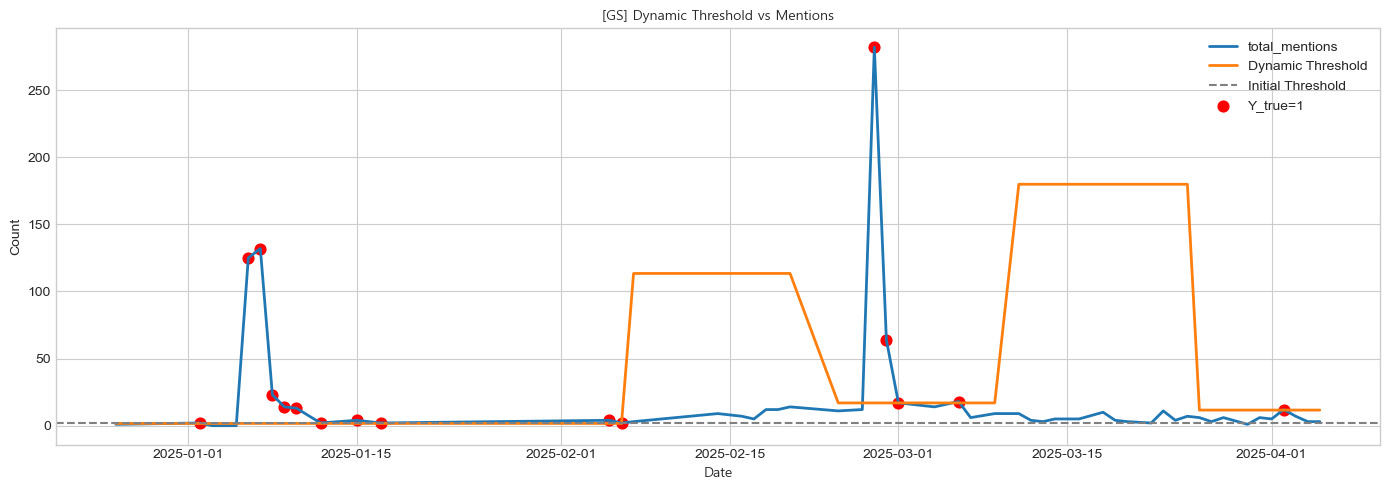

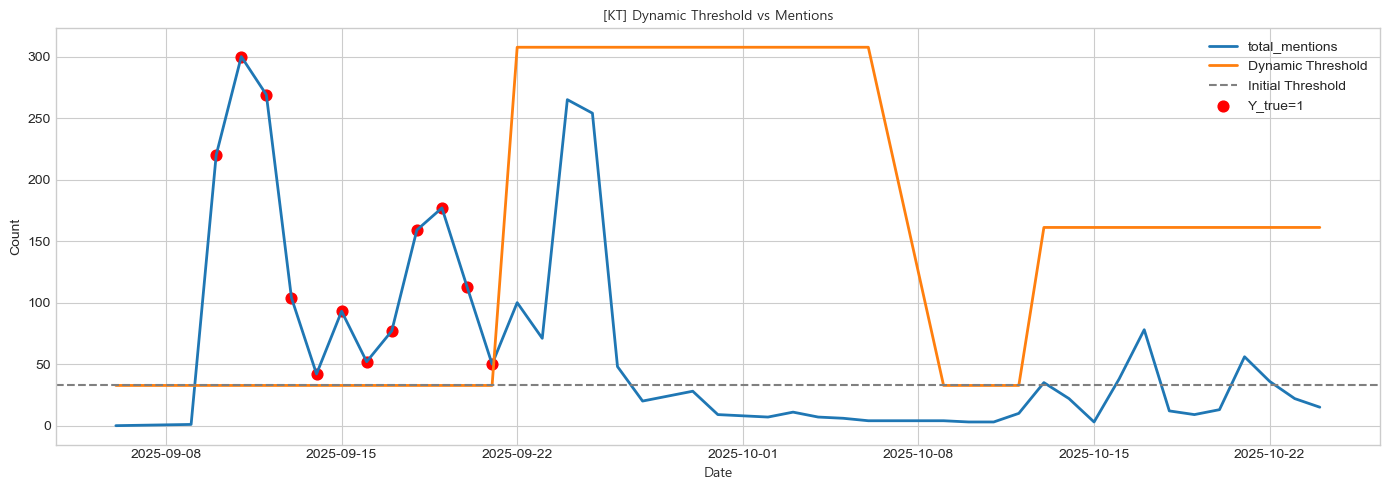

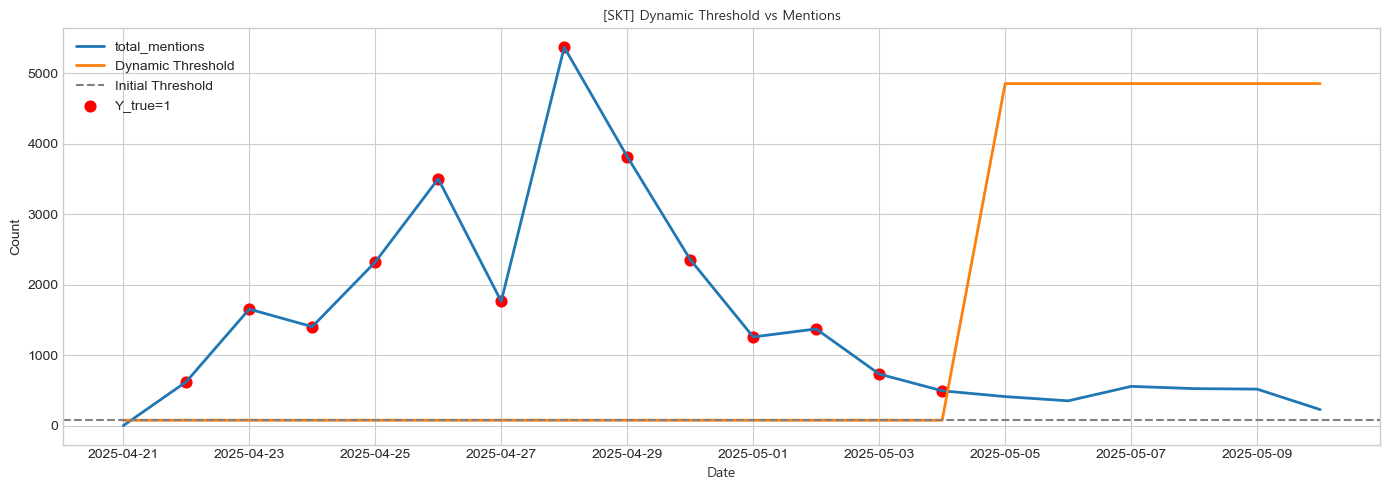

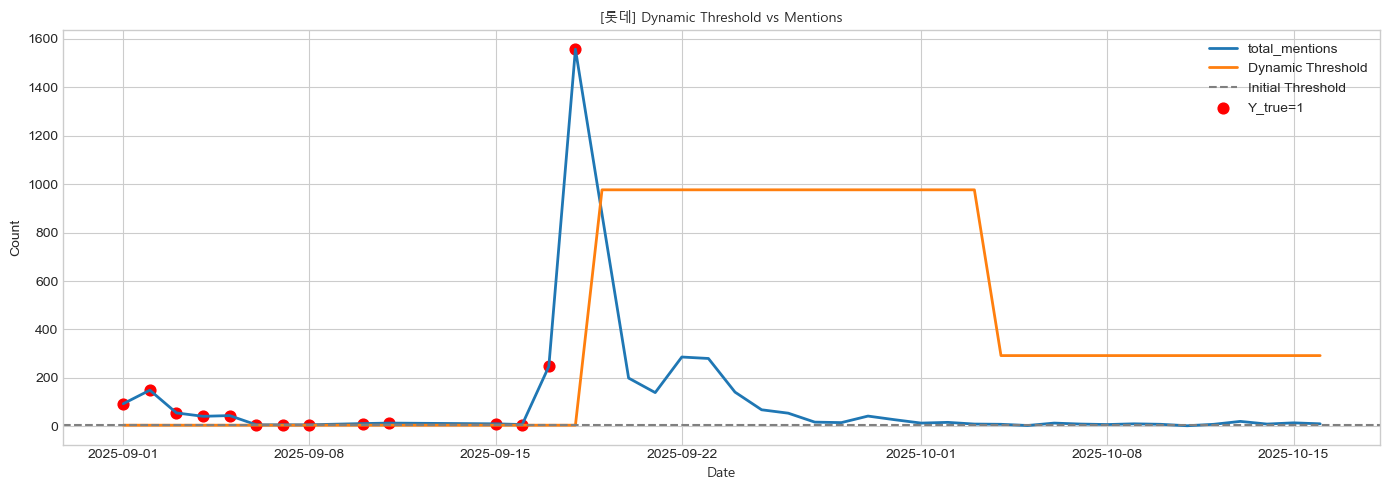

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

issues = df["issue"].unique()

for issue in issues:
    sub = df[df["issue"] == issue].sort_values("date")

    plt.figure(figsize=(14, 5))
    plt.plot(sub["date"], sub["total_mentions"], label="total_mentions", linewidth=2)
    plt.plot(sub["date"], sub["dyn_threshold"], label="Dynamic Threshold", linewidth=2)

    # baseline threshold (초기값)
    baseline_value = sub["threshold"].iloc[0]
    plt.axhline(baseline_value, color="gray", linestyle="--", label="Initial Threshold")

    # Y_true 표시 (빨간 점)
    anomaly = sub[sub["y_true"] == 1]
    plt.scatter(anomaly["date"], anomaly["total_mentions"], color="red", s=60, label="Y_true=1")

    # 한글 깨짐 방지: 폰트 지정 (예: 맑은 고딕)
    plt.title(f"[{issue}] Dynamic Threshold vs Mentions", fontsize=16, fontproperties="Malgun Gothic")
    plt.xlabel("Date", fontproperties="Malgun Gothic")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


ROC-AUC: 0.7204991087344028
최적 Cutoff: 0.02272434325673506
최대 F1-score: 0.6049382716049383
Precision: 0.45794392523364486
Recall: 0.8909090909090909
F1: 0.6049382716049383


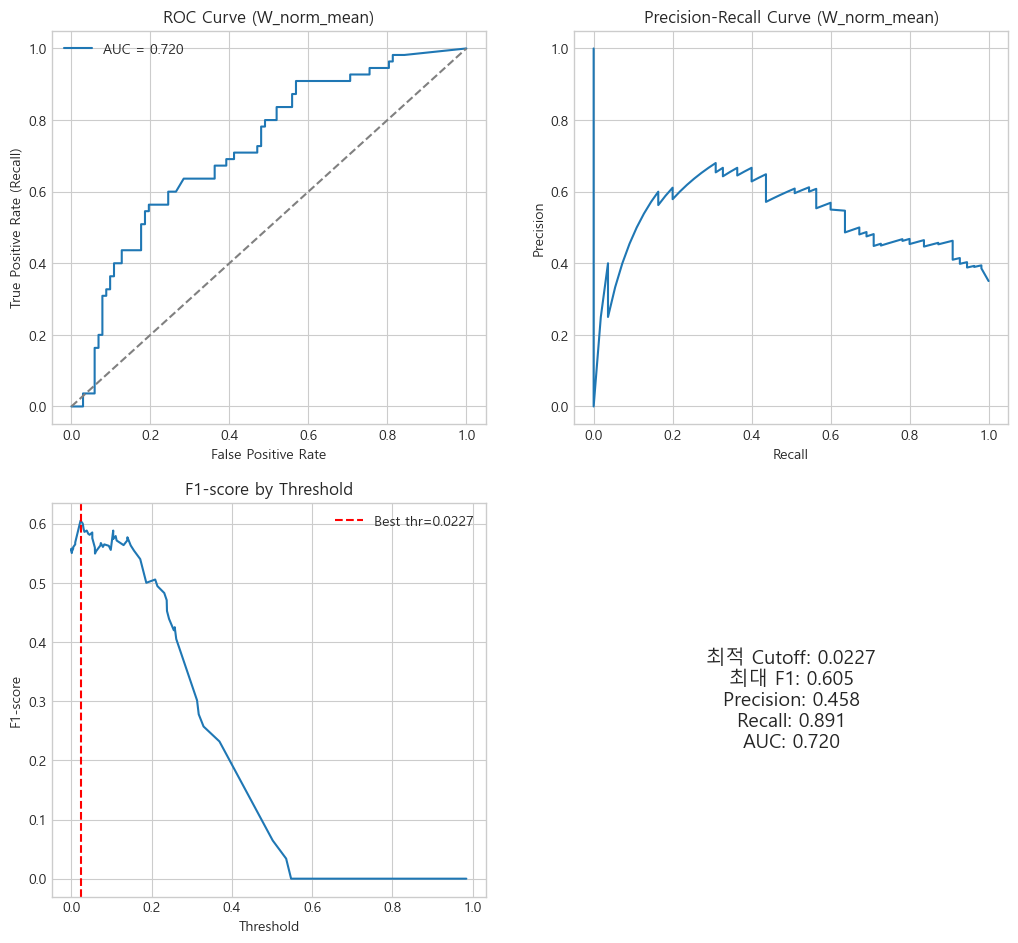

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve
)

# 한글 폰트 설정 (맑은 고딕 우선, 없으면 NanumGothic 설치 필요)
import platform
if platform.system() == 'Windows':
    font_path = "C:/Windows/Fonts/malgun.ttf"
elif platform.system() == 'Darwin':  # MacOS
    font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
else:  # Linux 환경, colab 등
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

try:
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)
except Exception as e:
    print("한글 폰트 설정 실패:", e)

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

# 데이터 준비
df_eval = df.copy()
df_eval = df_eval.dropna(subset=["W_norm_mean", "y_true"])

y_true = df_eval["y_true"].astype(int)
y_score = df_eval["W_norm_mean"].astype(float)

# ---------------------------
# 1) ROC-AUC 계산
# ---------------------------
auc = roc_auc_score(y_true, y_score)
print("ROC-AUC:", auc)

# ---------------------------
# 2) 최적 Cutoff 찾기 (F1 기준)
# ---------------------------
fpr, tpr, thresholds = roc_curve(y_true, y_score)

f1_list = []
for thr in thresholds:
    y_pred_temp = (y_score > thr).astype(int)
    f1_list.append(f1_score(y_true, y_pred_temp))

best_thr = thresholds[np.argmax(f1_list)]
best_f1 = max(f1_list)

print("최적 Cutoff:", best_thr)
print("최대 F1-score:", best_f1)

# 최종 예측 라벨
y_pred = (y_score > best_thr).astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1:", best_f1)

# ---------------------------
# 3) 시각화 (2x2 Subplot)
# ---------------------------
fig, axes = plt.subplots(2, 2, figsize=(11, 10))
fig.tight_layout(pad=4)

# ROC Curve
axes[0, 0].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
axes[0, 0].plot([0, 1], [0, 1], '--', color='grey')
axes[0, 0].set_xlabel("False Positive Rate")
axes[0, 0].set_ylabel("True Positive Rate (Recall)")
axes[0, 0].set_title("ROC Curve (W_norm_mean)")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Precision-Recall Curve
precision_vals, recall_vals, thr_pr = precision_recall_curve(y_true, y_score)
axes[0, 1].plot(recall_vals, precision_vals)
axes[0, 1].set_xlabel("Recall")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].set_title("Precision-Recall Curve (W_norm_mean)")
axes[0, 1].grid(True)

# F1-score vs Threshold
axes[1, 0].plot(thresholds, f1_list)
axes[1, 0].axvline(best_thr, color='red', linestyle='--', label=f"Best thr={best_thr:.4f}")
axes[1, 0].set_xlabel("Threshold")
axes[1, 0].set_ylabel("F1-score")
axes[1, 0].set_title("F1-score by Threshold")
axes[1, 0].legend()
axes[1, 0].grid(True)

# 빈 플롯 (또는 추가 정보가 있다면 여기에)
axes[1, 1].axis('off')
axes[1, 1].text(0.5, 0.5,
    f"최적 Cutoff: {best_thr:.4f}\n최대 F1: {best_f1:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nAUC: {auc:.3f}",
    fontsize=14, ha='center', va='center', fontweight='bold', fontproperties=font_manager.FontProperties(fname=font_path)
)

plt.show()
